In [1]:
import os
os.chdir("../")
with open('run/settings.py', 'r') as file:
    exec(file.read())

Random seed set to 333
using device:  cpu


# Configuration (customizable)

In [2]:
overwrite = False
model_name = 'syn4' 

text1 = ('No trend.',1)
text2 = ('No seasonal pattern.',1)
text3 = ('No sharp shifts.',1)
text4 = ("The time series exhibits low variability.", 1)
counter_text11 = ('The time series shows upward linear trend.',1)
counter_text12 = ('The time series shows downward linear trend.',1)
counter_text13 = ('The time series shows upward quadratic trend.',3)
counter_text14 = ('The time series shows downward quadratic trend.',3)
counter_text2 = ('The time series exhibits a seasonal pattern.',5)
counter_text31 = ('The mean of the time series shifts upwards.',10)
counter_text32 = ('The mean of the time series shifts downwards.',10)
counter_text4 = ("The time series exhibits high variability.", 3)


text_config = {'text_pairs': [
                    [text1, counter_text11, counter_text12, counter_text13, counter_text14],
                    [text2, counter_text2],
                    [text3, counter_text31, counter_text32],
                    [text4, counter_text4]
                ],  'n': None}

attr_id = 3 # y_col by the third attribute (third element in the text_config['text_pairs'])
update_config(
    
    # Eval settings (clip)
    # ts2txt
    y_col = 'segment'+str(attr_id),
    y_levels = [t[0]for t in text_config['text_pairs'][attr_id-1]],
    y_pred_levels =[t[0]for t in text_config['text_pairs'][attr_id-1]],
    # txt2ts
    txt2ts_y_cols = ['segment1', 'segment2', 'segment3', 'segment4'],
    
    
    # Data settings
    text_col = 'text', #'ts_description',
    seq_length = 200,
    downsample = True,
    downsample_size = 13000,
    downsample_levels = [t[0]for t in text_config['text_pairs'][attr_id-1]],
    custom_target_cols = ['segment1', 'segment2', 'segment3', 'segment4', 'label'], # 'label' is the same as the default "by_label" target
    
    
    # Model settings
    model_name = model_name,
    **{'3d': False},  # Add this line
    embedded_dim = 512,
    concat_embeddings = False,
    clip_mu = False,
    variational = True,
    train_type = 'joint', # or 'vae', 'clip'
    clip_target_type = 'by_target', # or 'by_label'
    
    # Train settings
    batch_size = 512,
    init_lr = 1e-4,
    patience = 100,
    alpha = 1/500,
    num_saves = 10,
    num_epochs = 500,
    
    # Text configuration
    text_config = text_config
)
config_dict = get_config_dict()



# Data

In [3]:
# change data preparation for a given experiment
with open('run/prepare_datasets/synthetic.py', 'r') as file:
    exec(file.read())
# prepare model inputs
with open('run/inputs.py', 'r') as file:
    exec(file.read())

text
No trend. No seasonal pattern. No sharp shifts. The time series exhibits low variability.                                                                                                10000
No trend. No seasonal pattern. No sharp shifts. The time series exhibits high variability.                                                                                               10000
The time series shows downward linear trend. The time series exhibits a seasonal pattern. The mean of the time series shifts upwards. The time series exhibits low variability.          10000
The time series shows downward linear trend. The time series exhibits a seasonal pattern. The mean of the time series shifts upwards. The time series exhibits high variability.         10000
The time series shows downward linear trend. The time series exhibits a seasonal pattern. The mean of the time series shifts downwards. The time series exhibits low variability.        10000
The time series shows downward linear tr

# Model (customizable)

In [4]:
# customize encoder and decoder here. 
ts_encoder = MultiCNNEncoder(ts_dim = ts_f_dim.shape[1],
                             output_dim=config_dict['embedded_dim'],
                             kernel_sizes=[100, 50, 20, 5],
                             hidden_num_channel=16,
                             dropout=0)
ts_decoder = TransformerDecoder(ts_dim = ts_f_dim.shape[1], output_dim = config_dict['embedded_dim']+2, 
                 nhead = 8,
                 num_layers = 6,
                 dim_feedforward = 512,
                 dropout = 0.1)
text_encoder = TextEncoderMultiCNN(text_dim = tx_f_dim.shape[1],
                                   output_dim=config_dict['embedded_dim'],
                                   kernel_sizes=[500, 250, 100],  # Different context windows
                                   hidden_num_channel=16,
                                   dropout=0.0)
# overwrite = False
with open('run/model.py', 'r') as file:
    exec(file.read())


Layer (type:depth-idx)                                                      Param #
VITAL                                                                       1
├─TSVAEEncoder: 1-1                                                         --
│    └─LocalNorm: 2-1                                                       --
│    └─MultiCNNEncoder: 2-2                                                 512
│    │    └─ModuleList: 3-1                                                 3,281,840
│    │    └─MultiheadAttention: 3-2                                         1,050,624
│    │    └─LayerNorm: 3-3                                                  1,024
│    └─Linear: 2-3                                                          262,656
│    └─Linear: 2-4                                                          262,656
├─TextEncoder: 1-2                                                          --
│    └─TextEncoderMultiCNN: 2-5                                             512
│    │    └─ModuleL

# Train

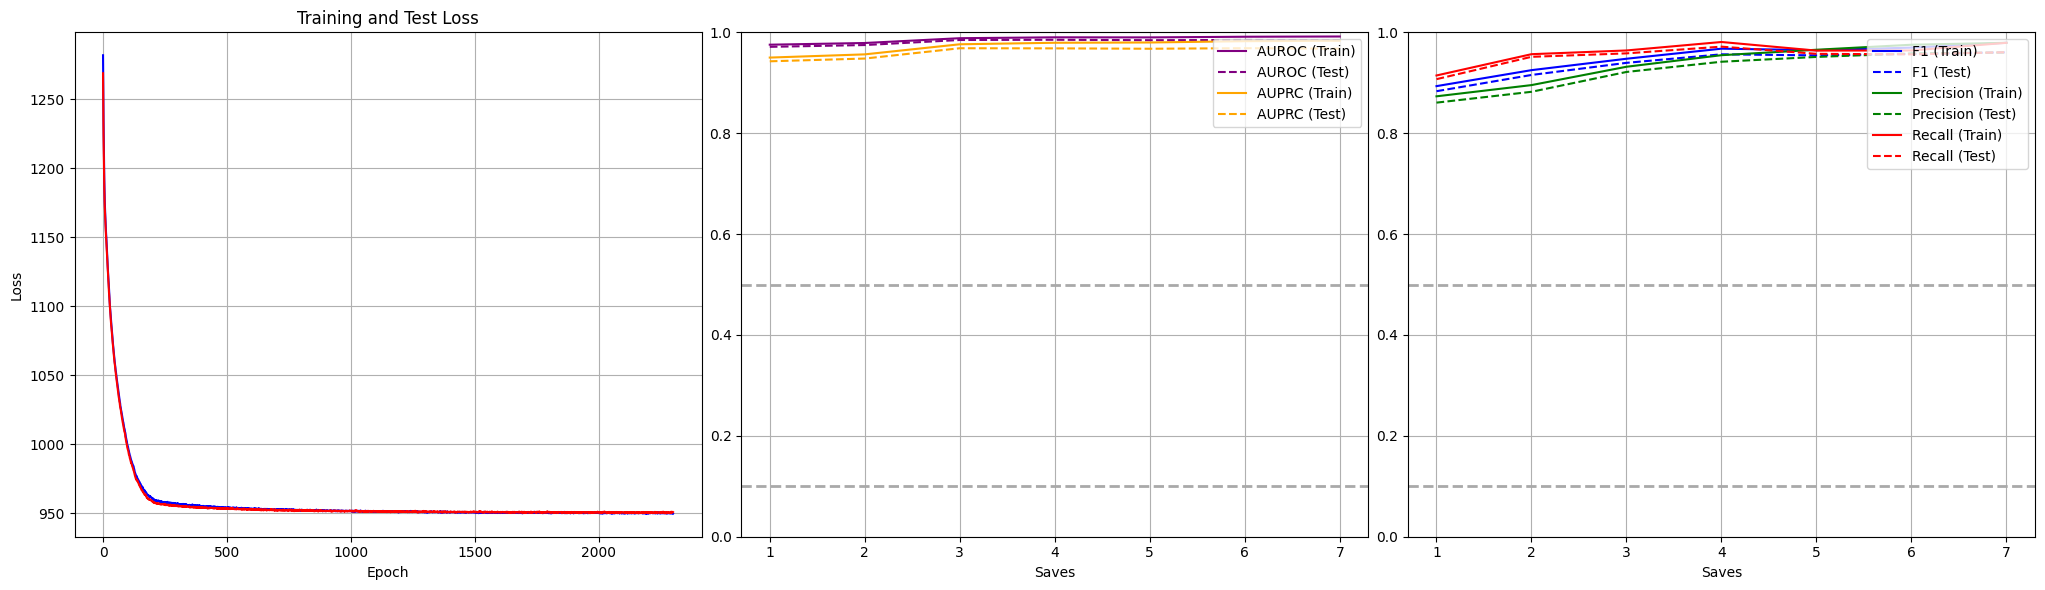

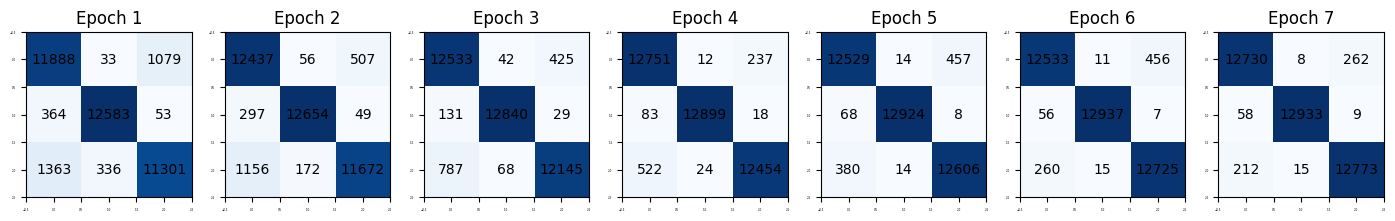

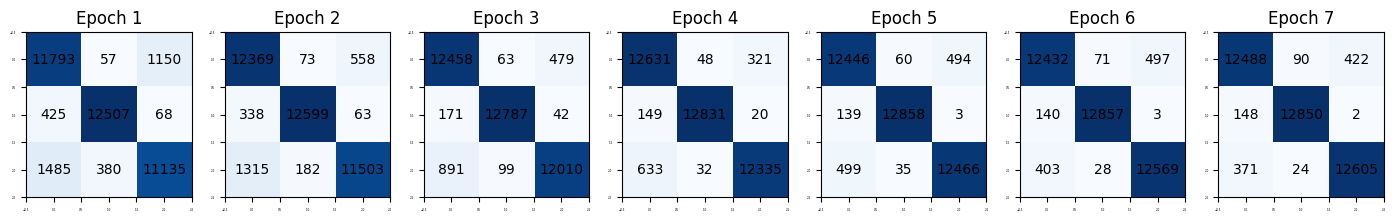

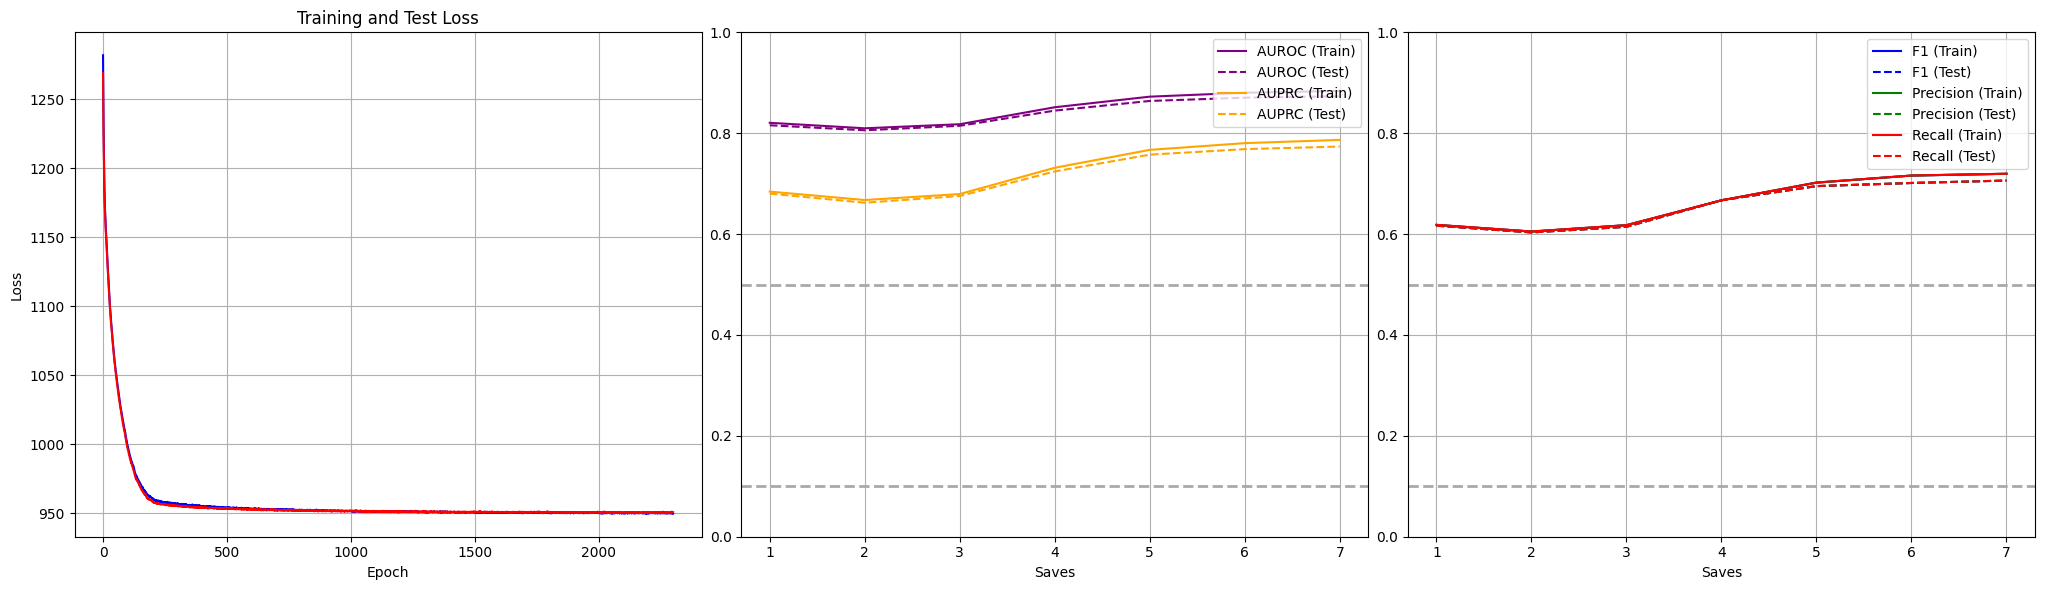

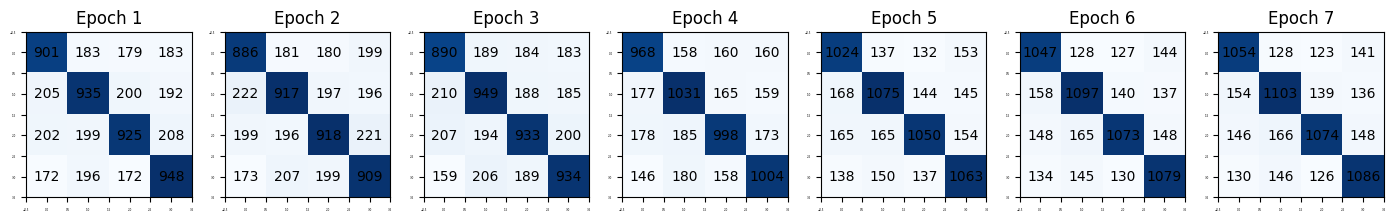

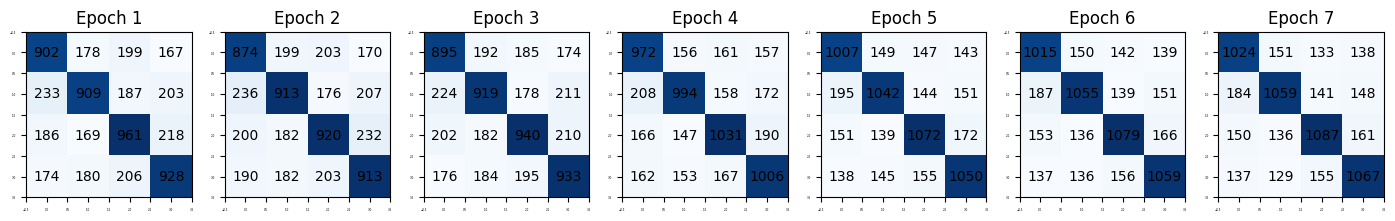

KeyboardInterrupt: 

In [5]:
# overwrite = False
with open('run/train.py', 'r') as file:
    exec(file.read())


# Generation

0    The time series shows upward linear trend.
Name: segment1, dtype: object


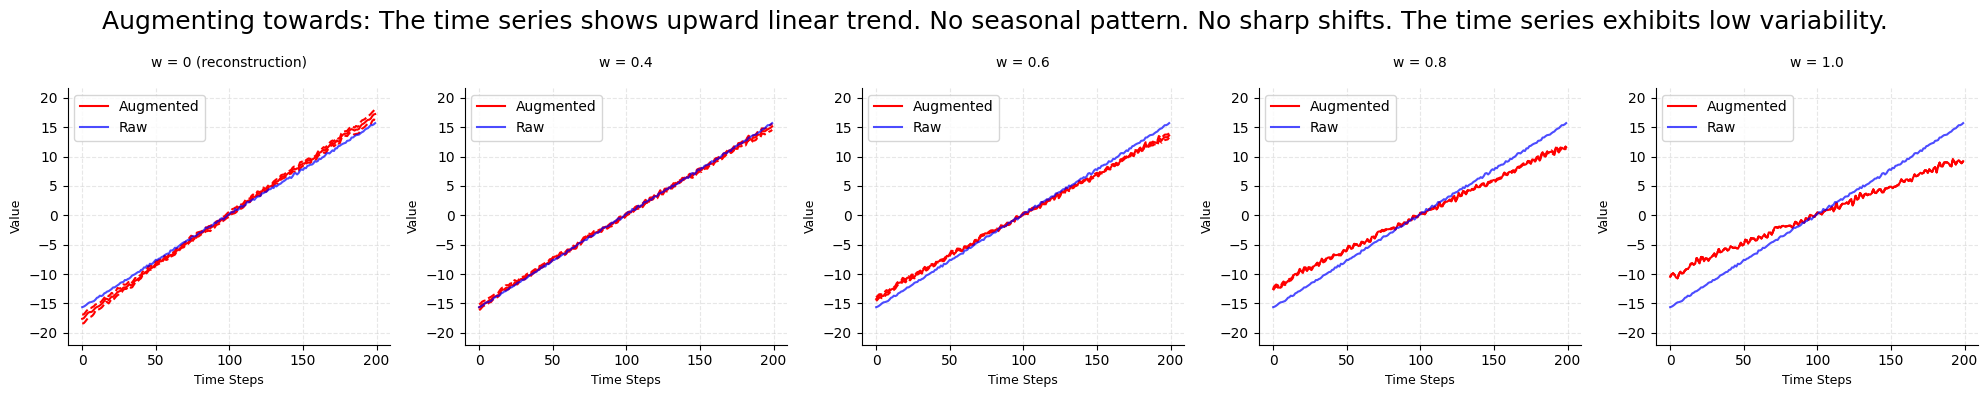

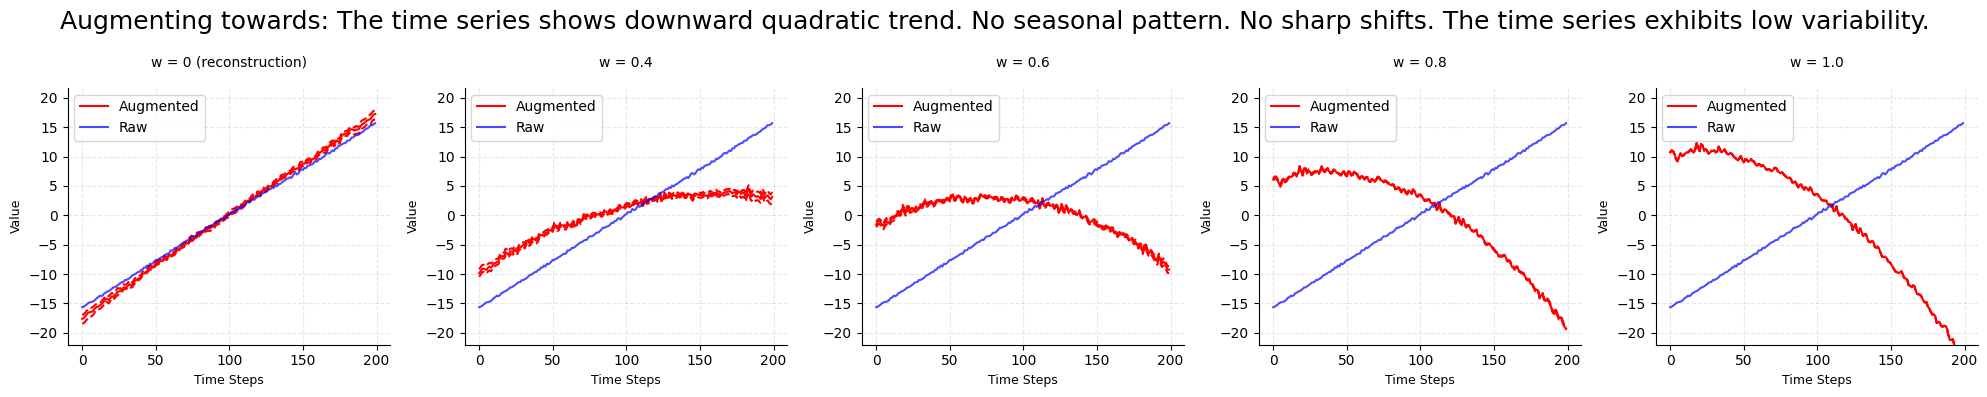

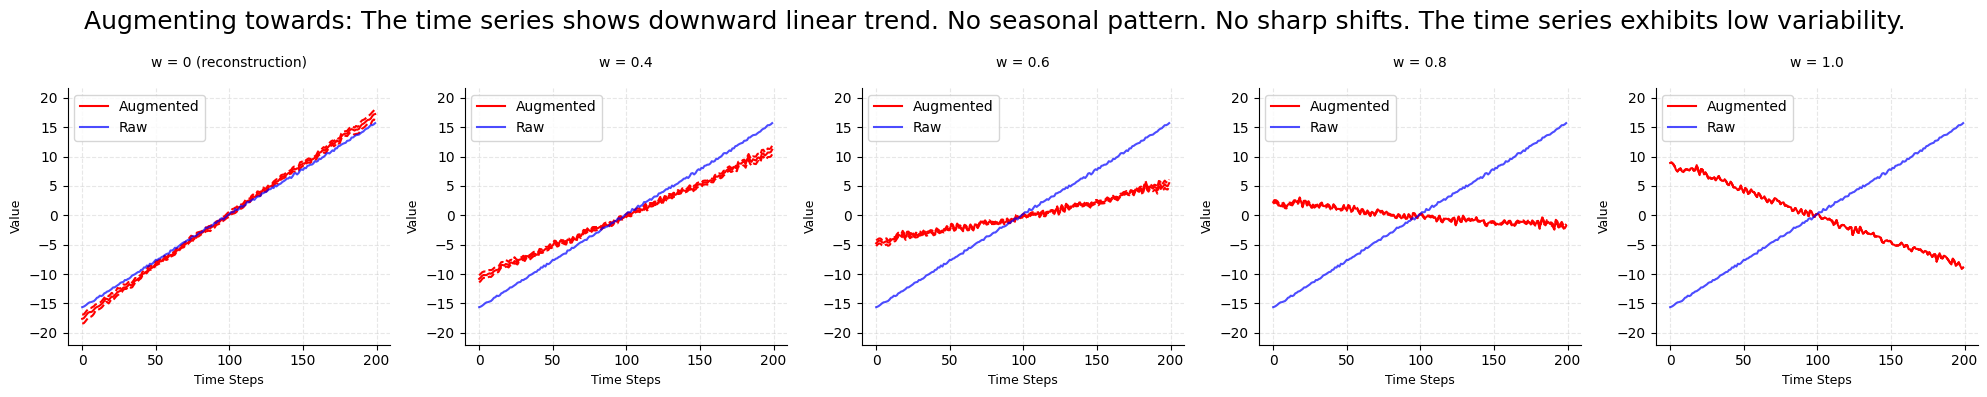

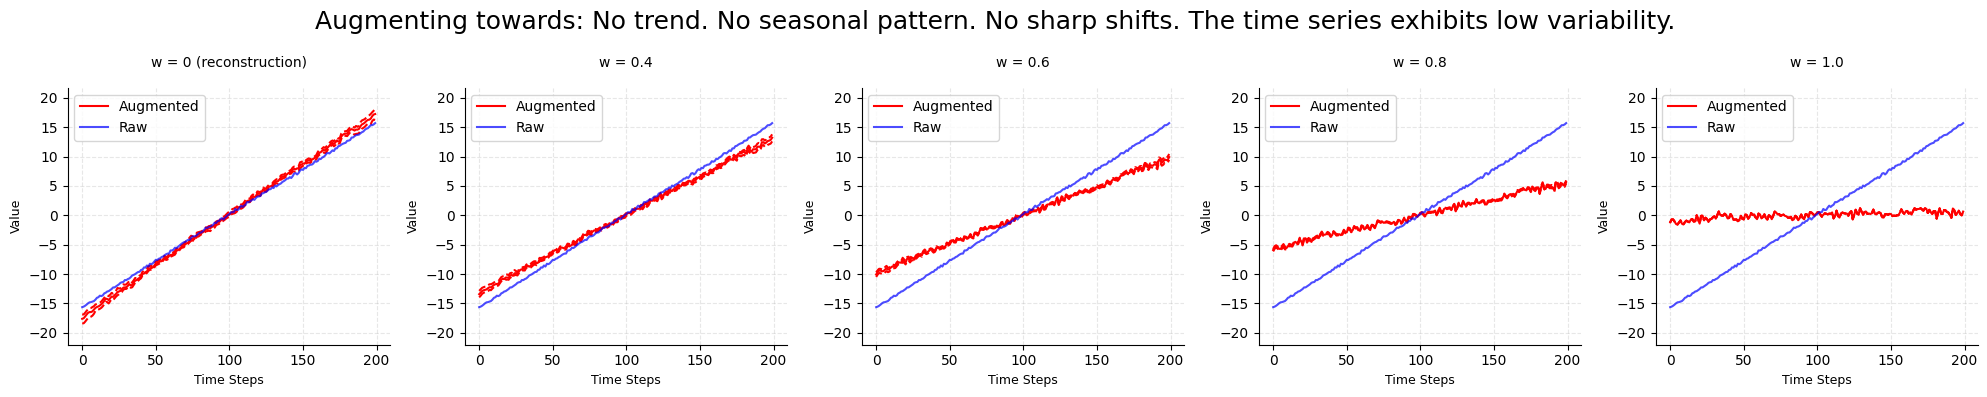

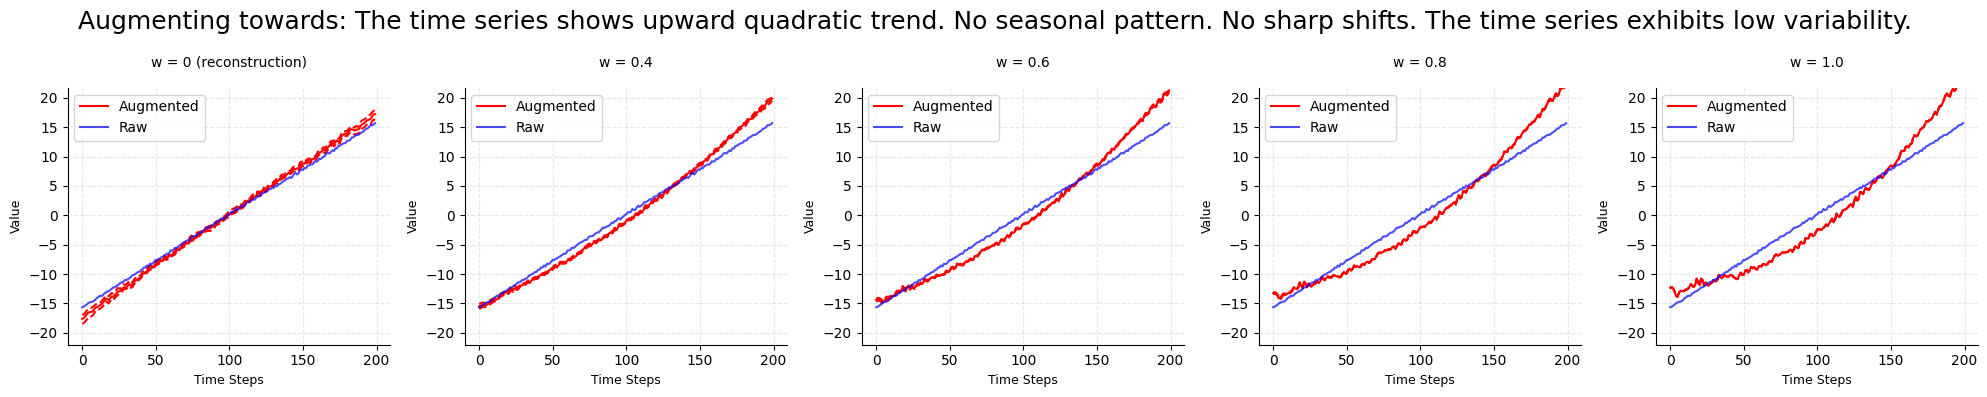

0    The time series shows downward quadratic trend.
Name: segment1, dtype: object


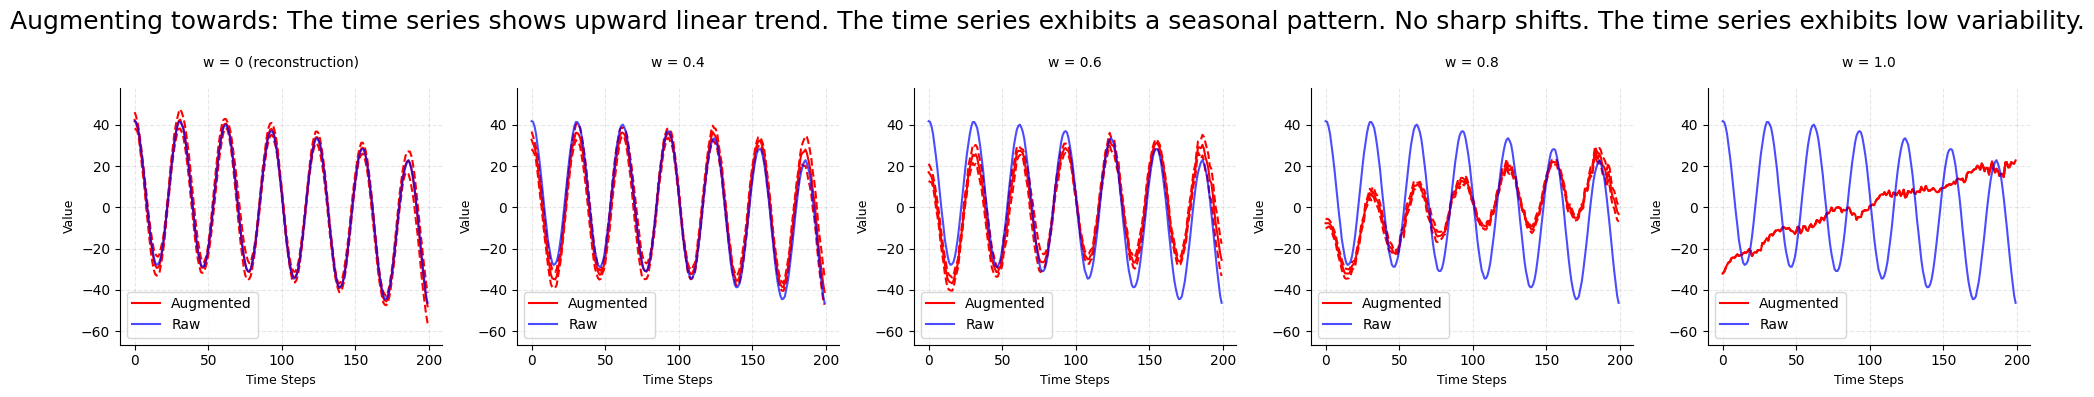

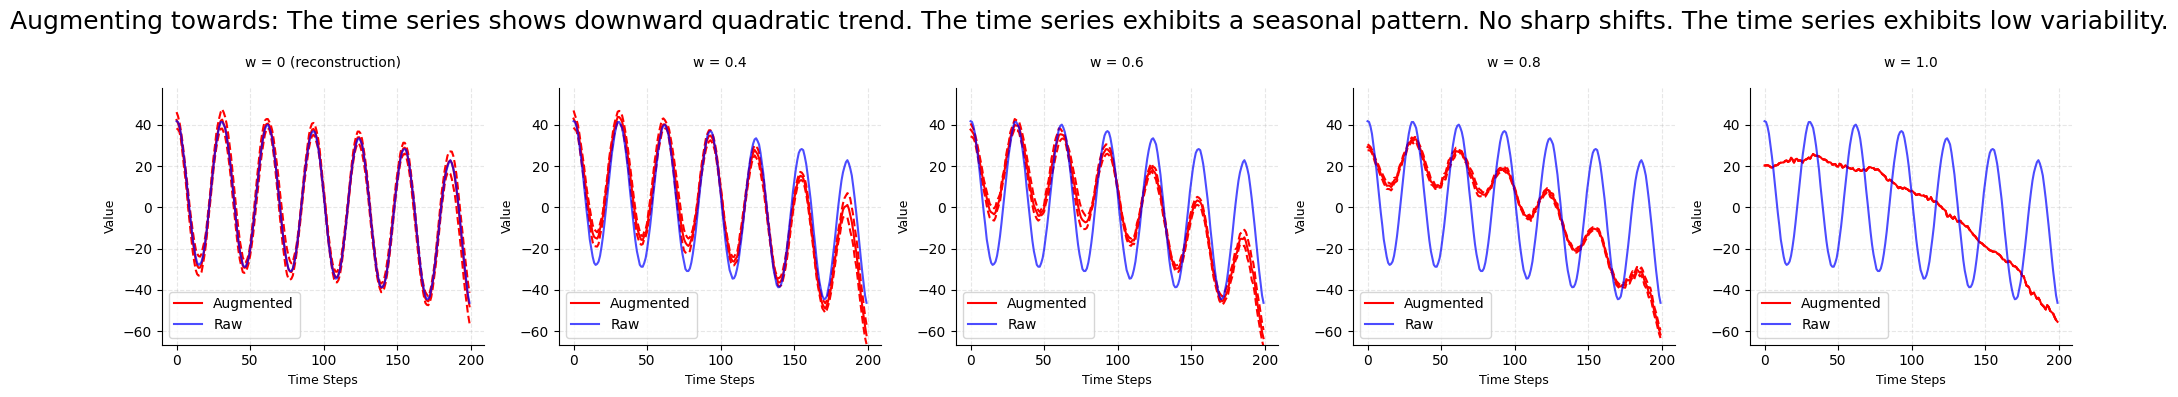

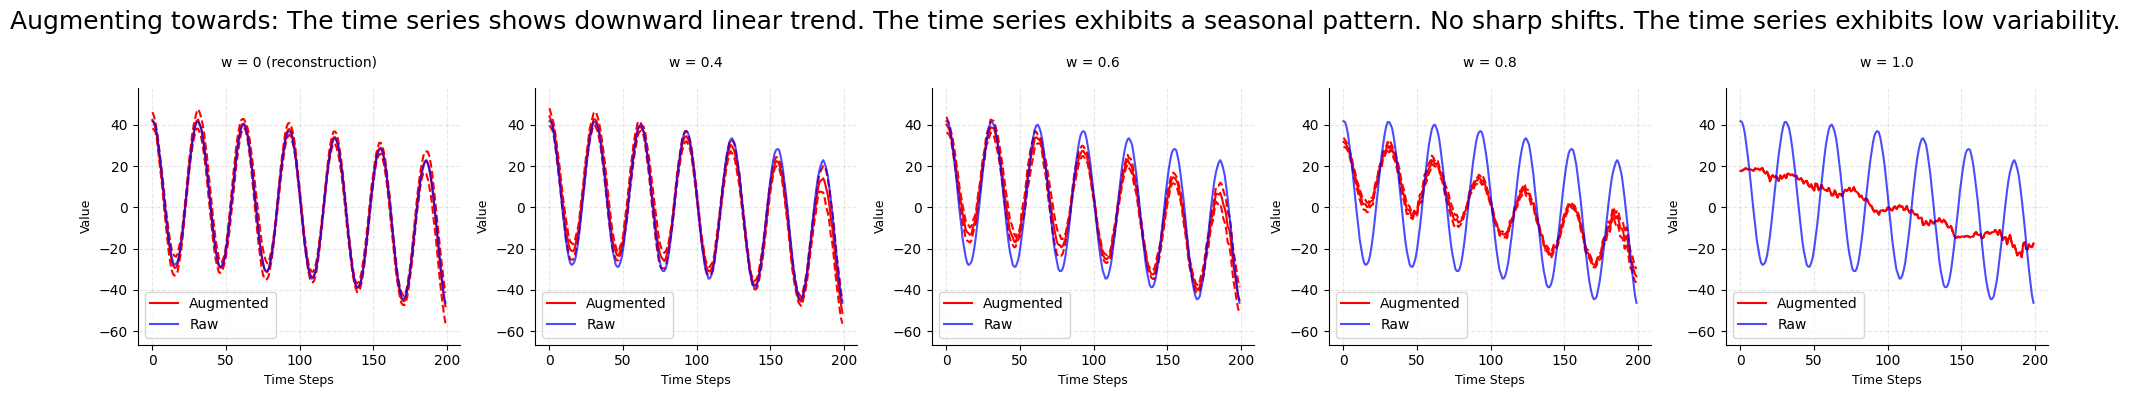

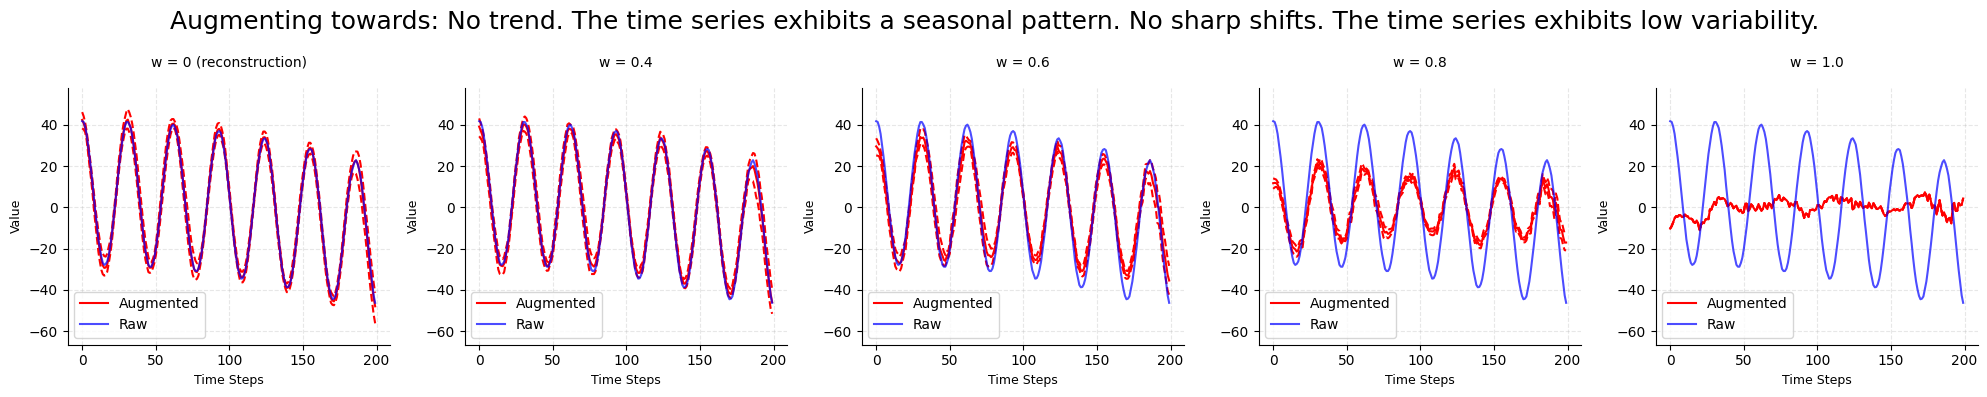

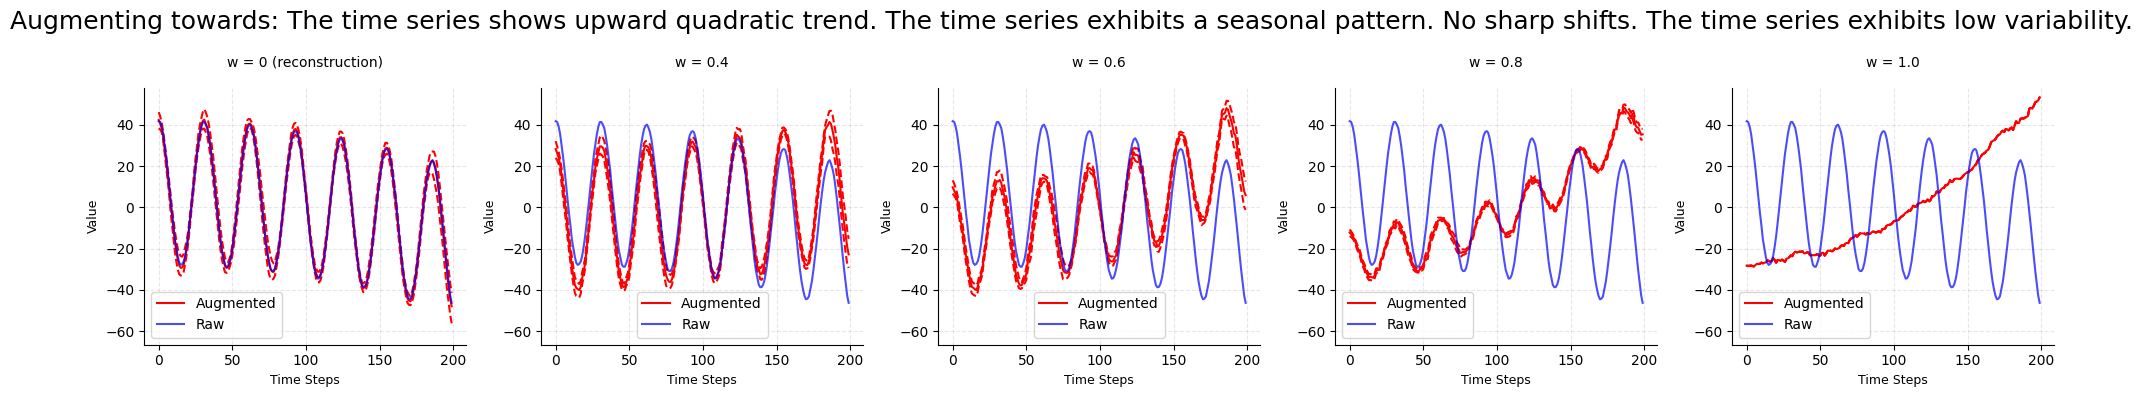

0    The time series shows downward linear trend.
Name: segment1, dtype: object


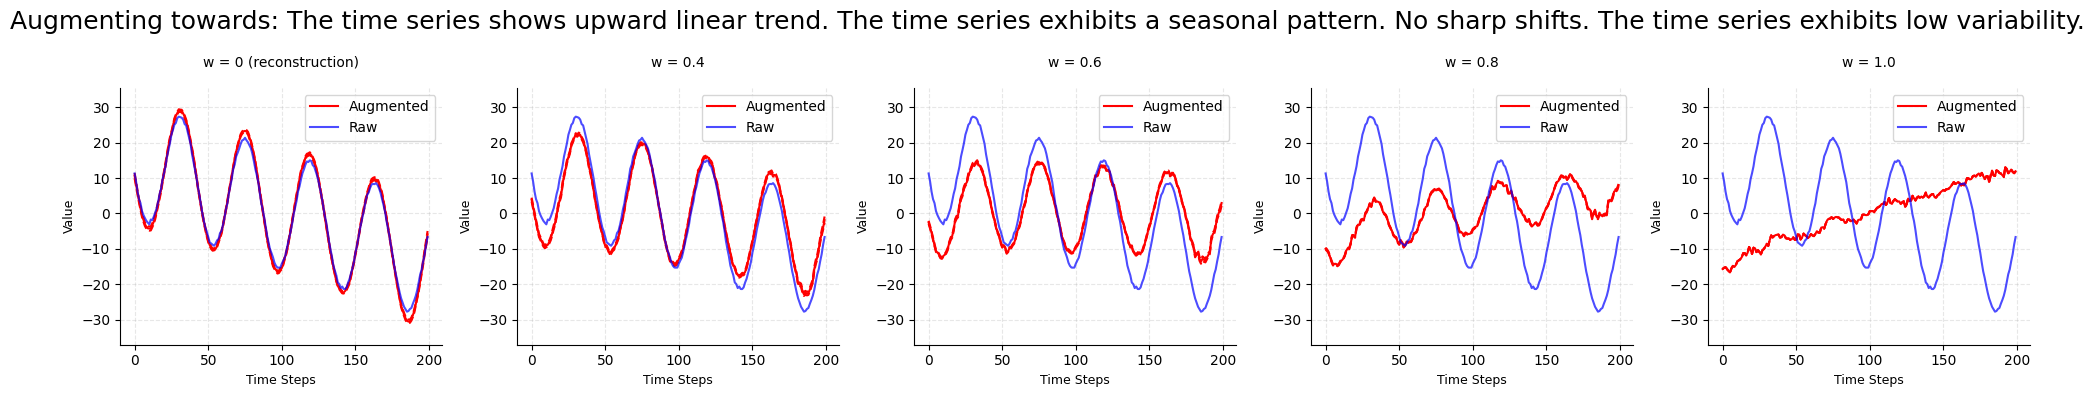

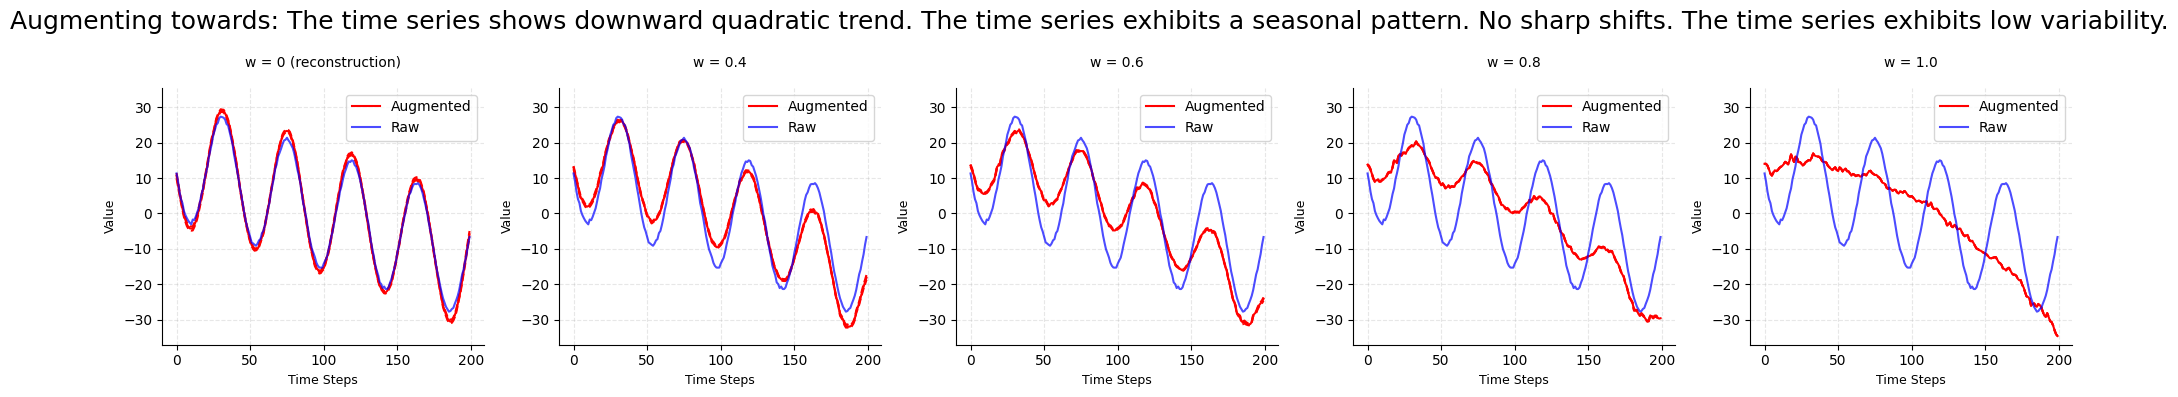

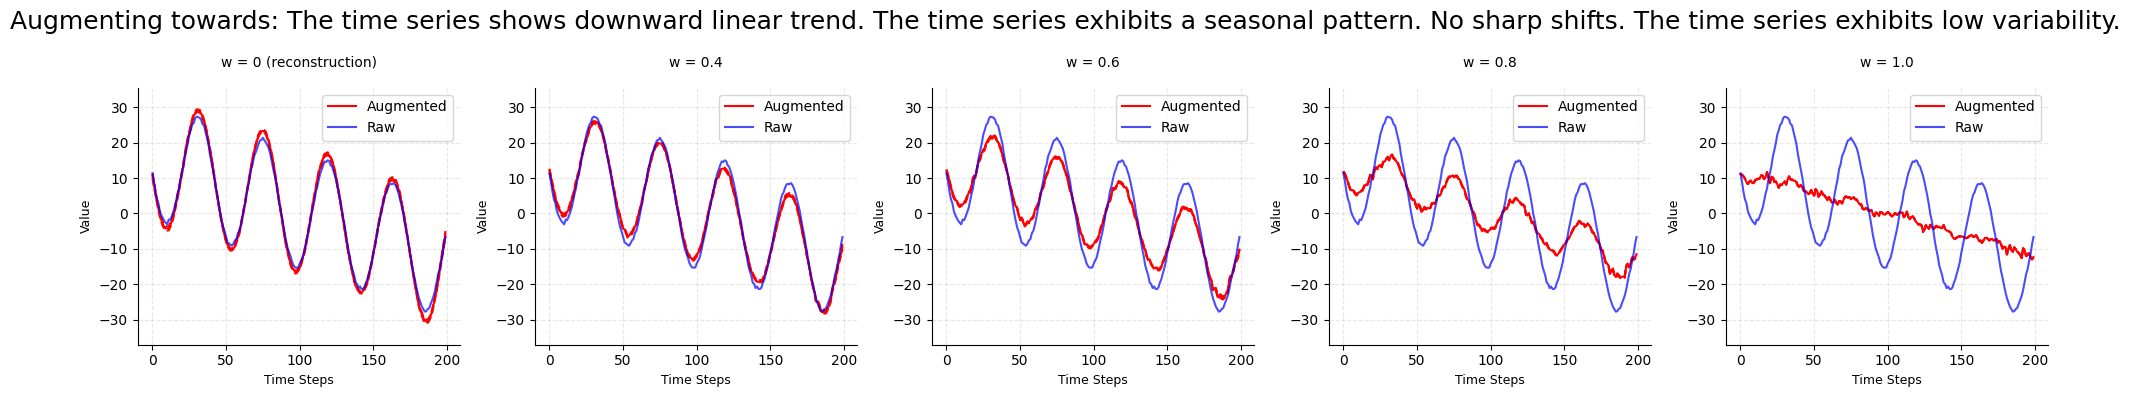

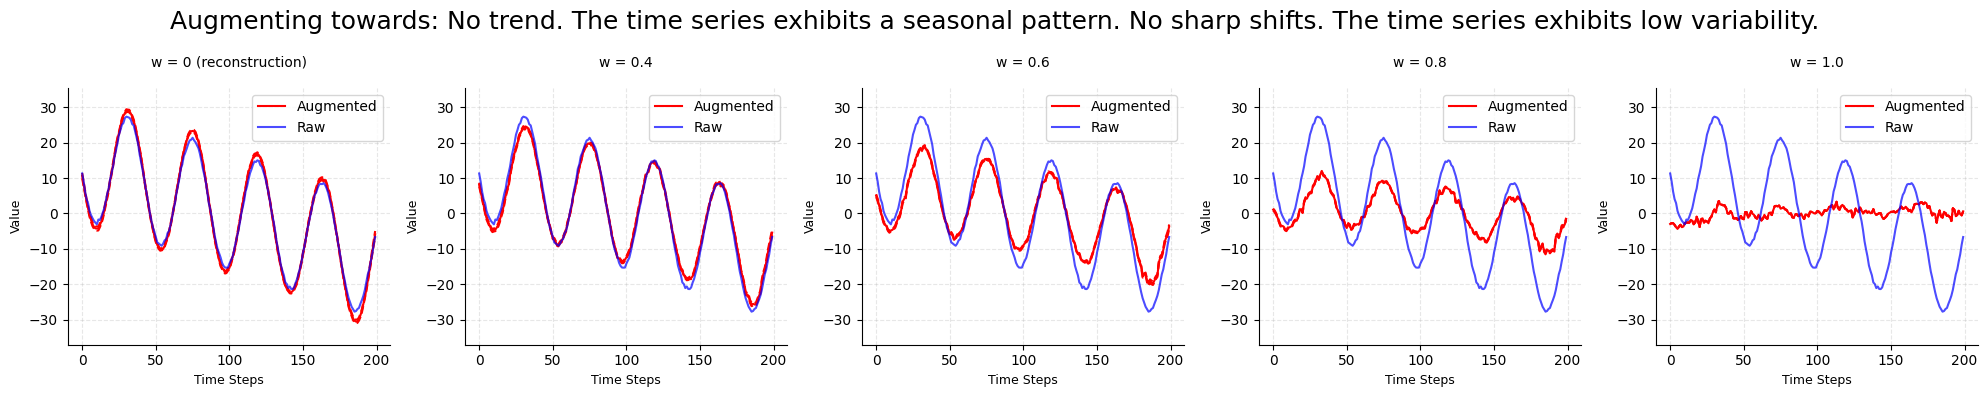

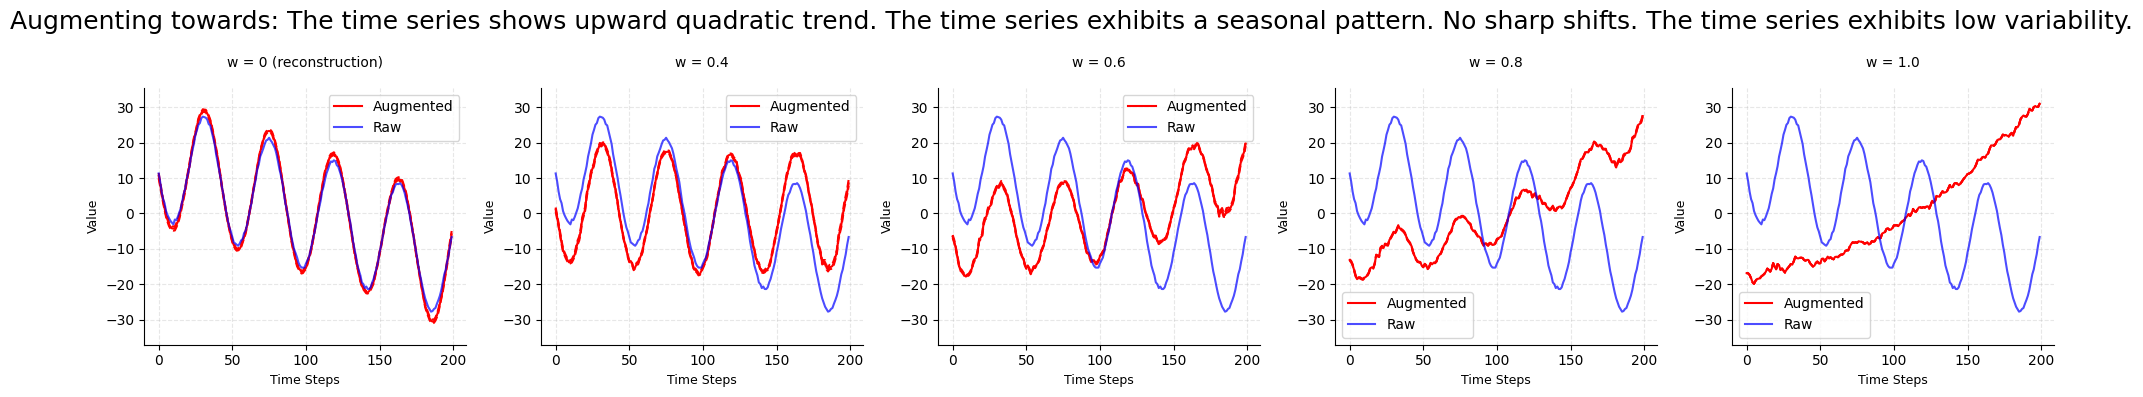

0    No trend.
Name: segment1, dtype: object


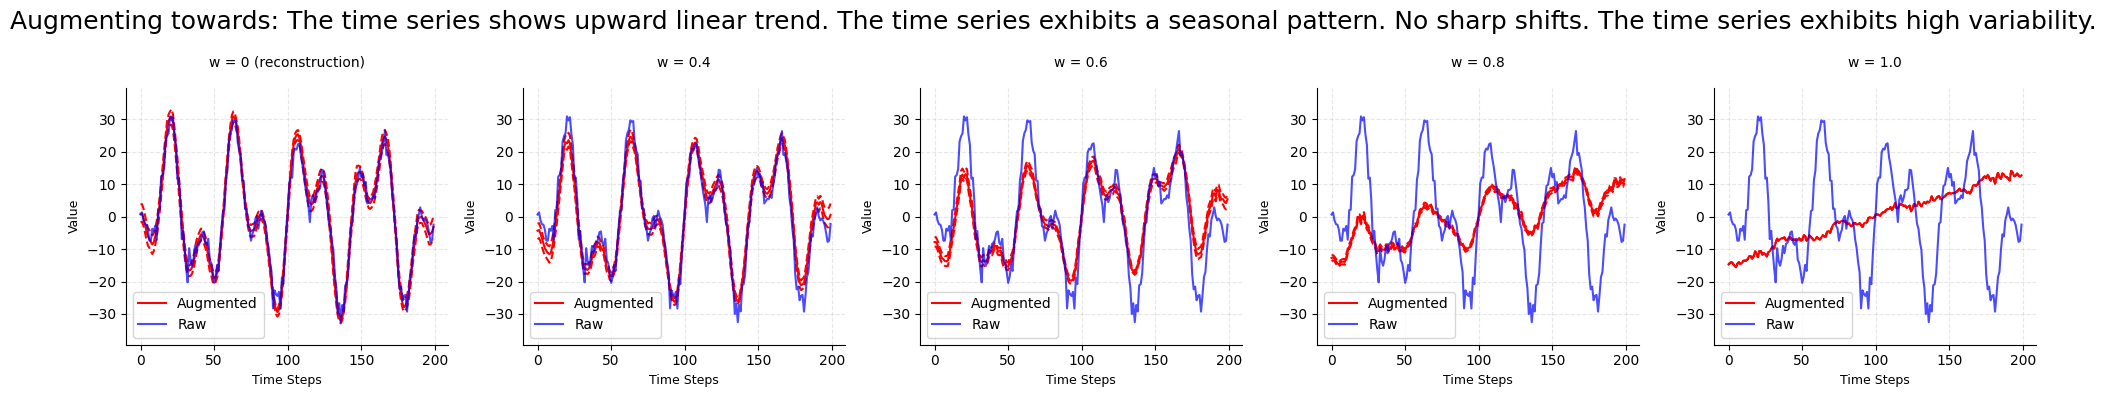

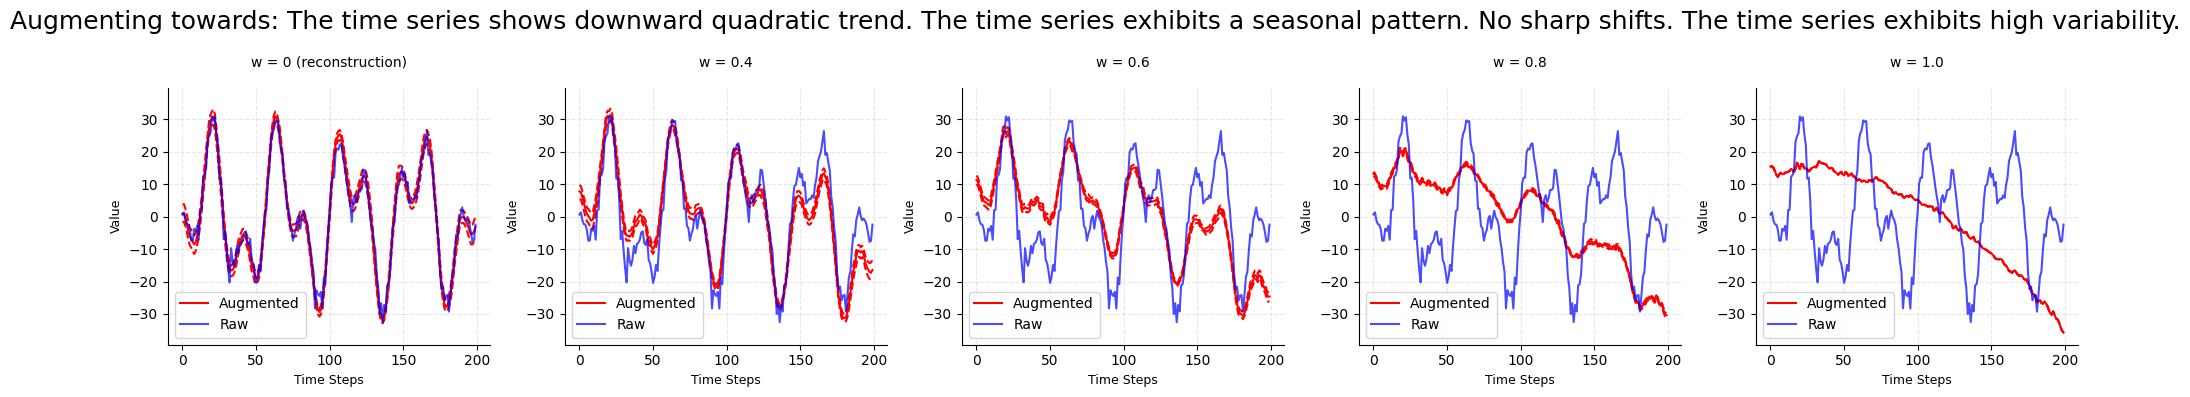

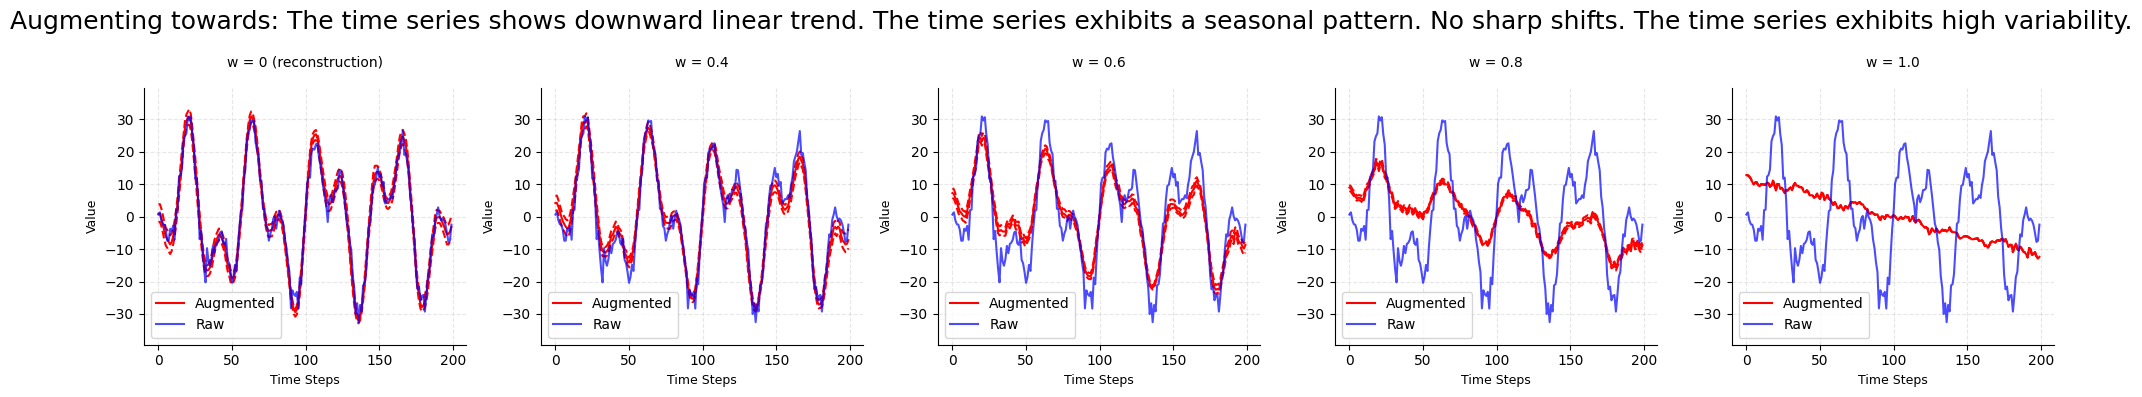

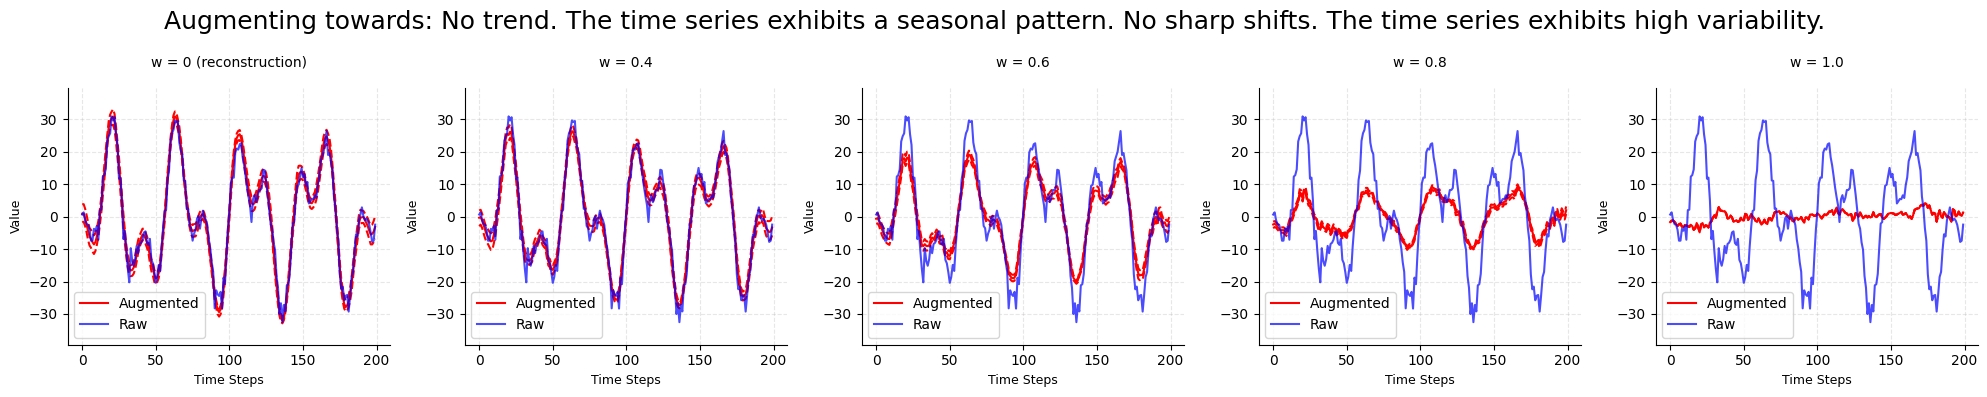

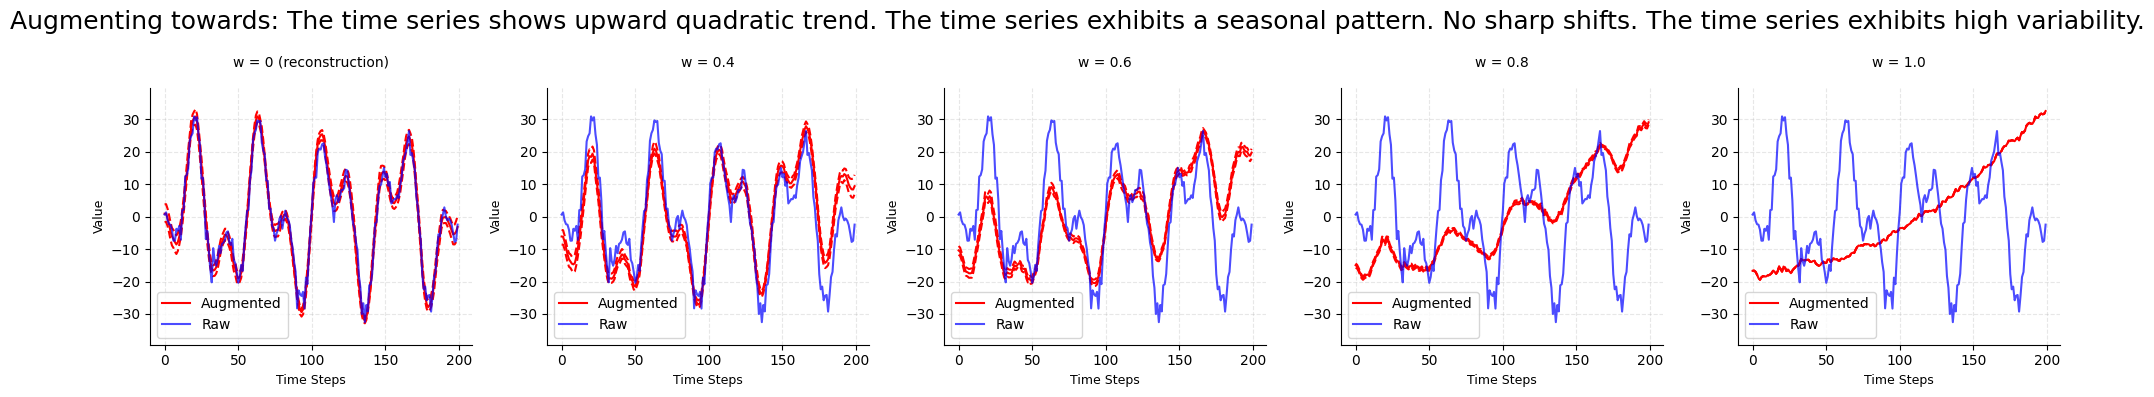

0    The time series shows upward quadratic trend.
Name: segment1, dtype: object


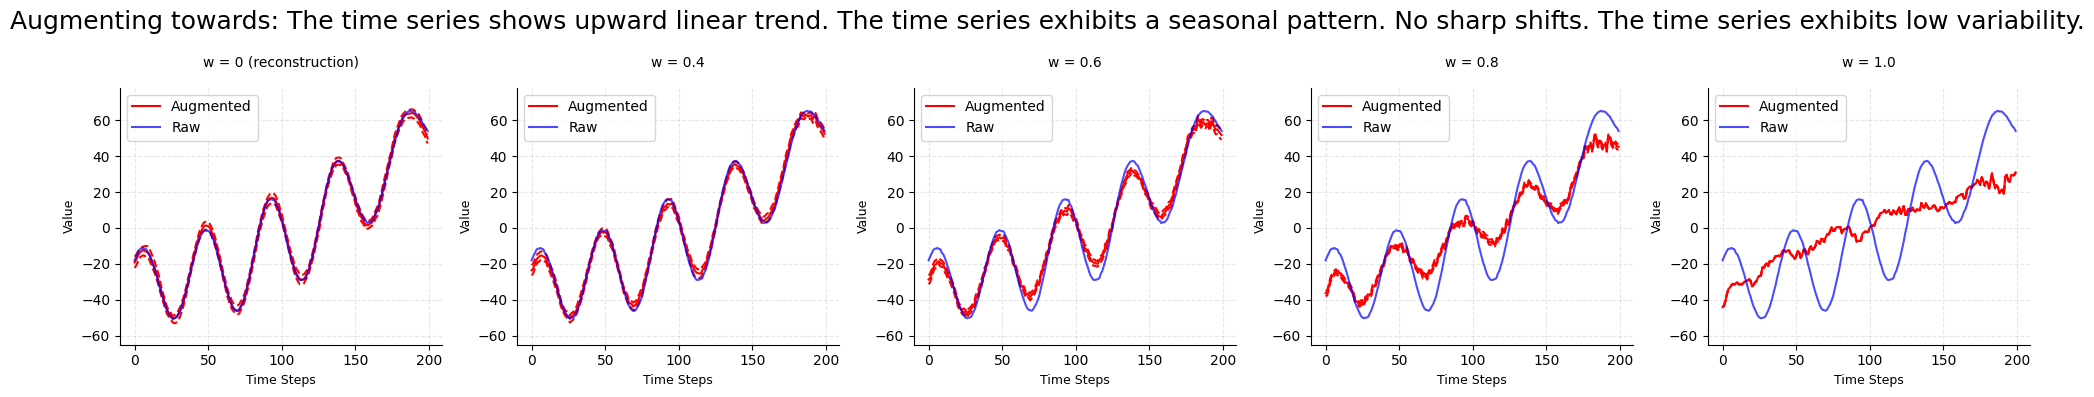

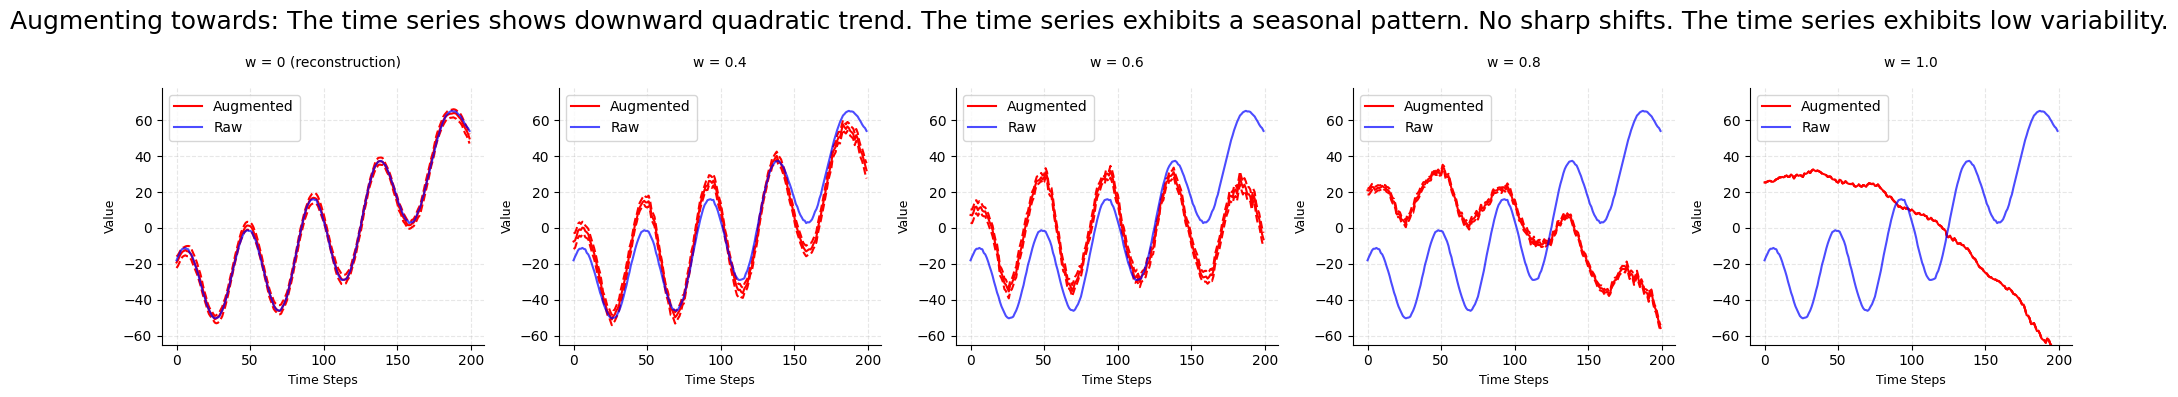

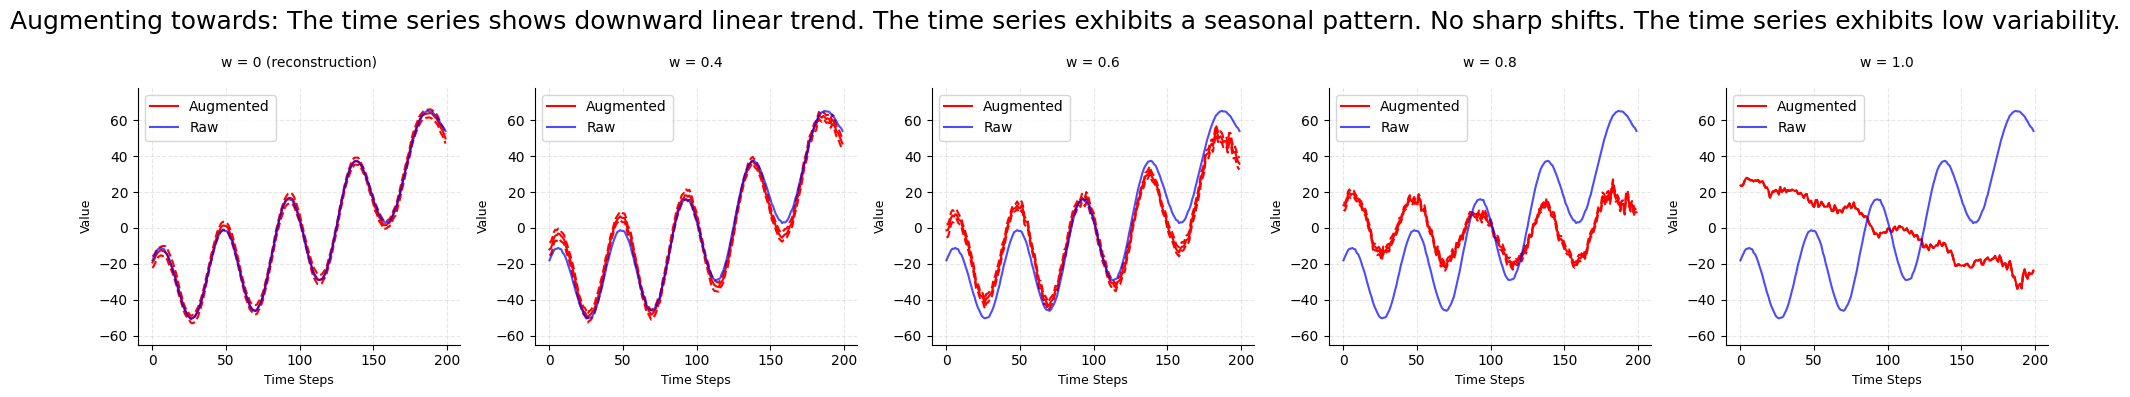

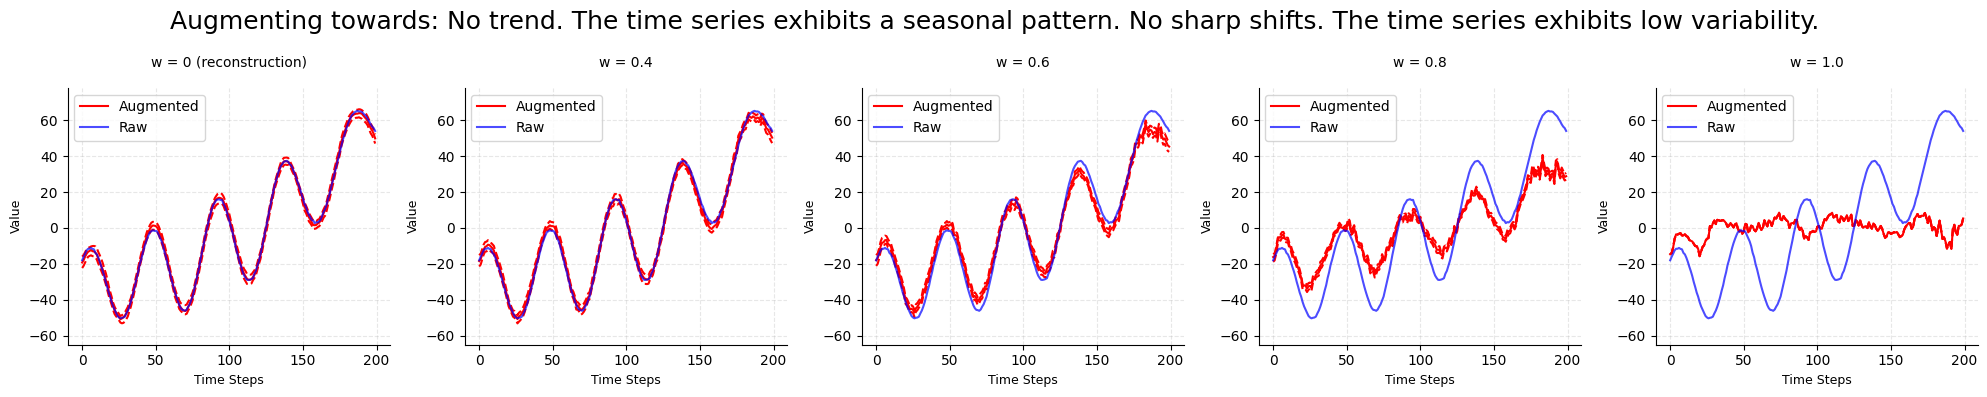

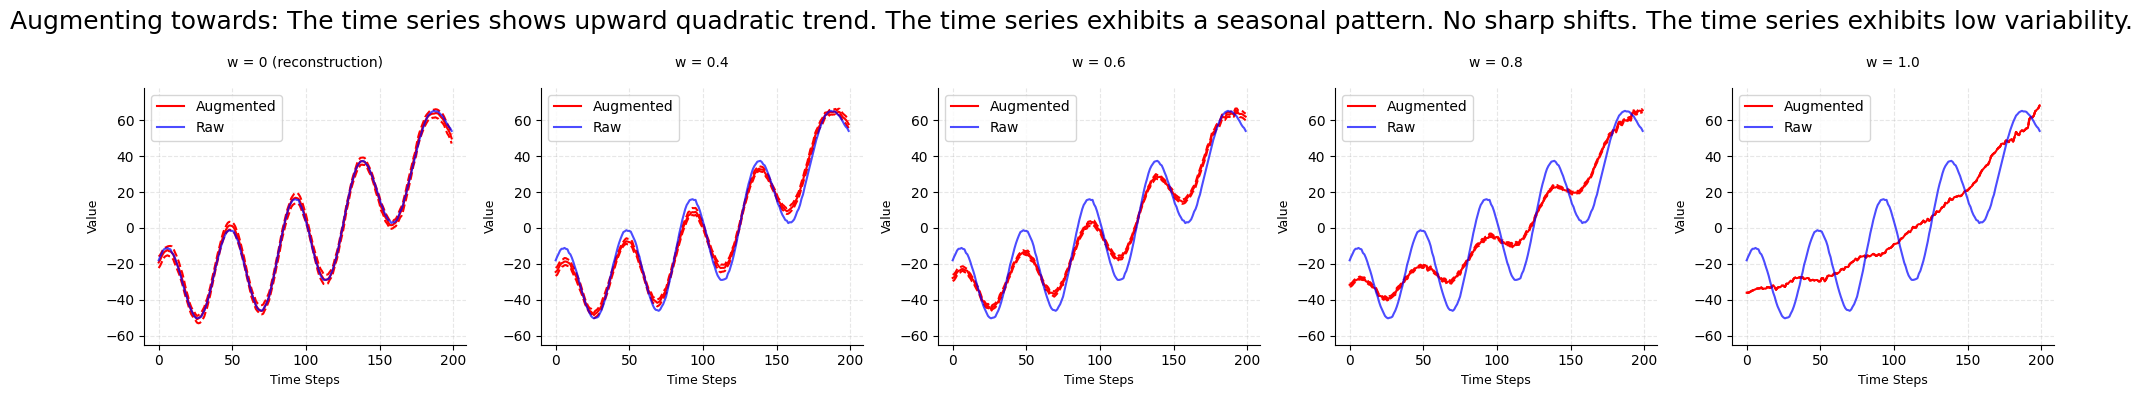

0    No seasonal pattern.
Name: segment2, dtype: object


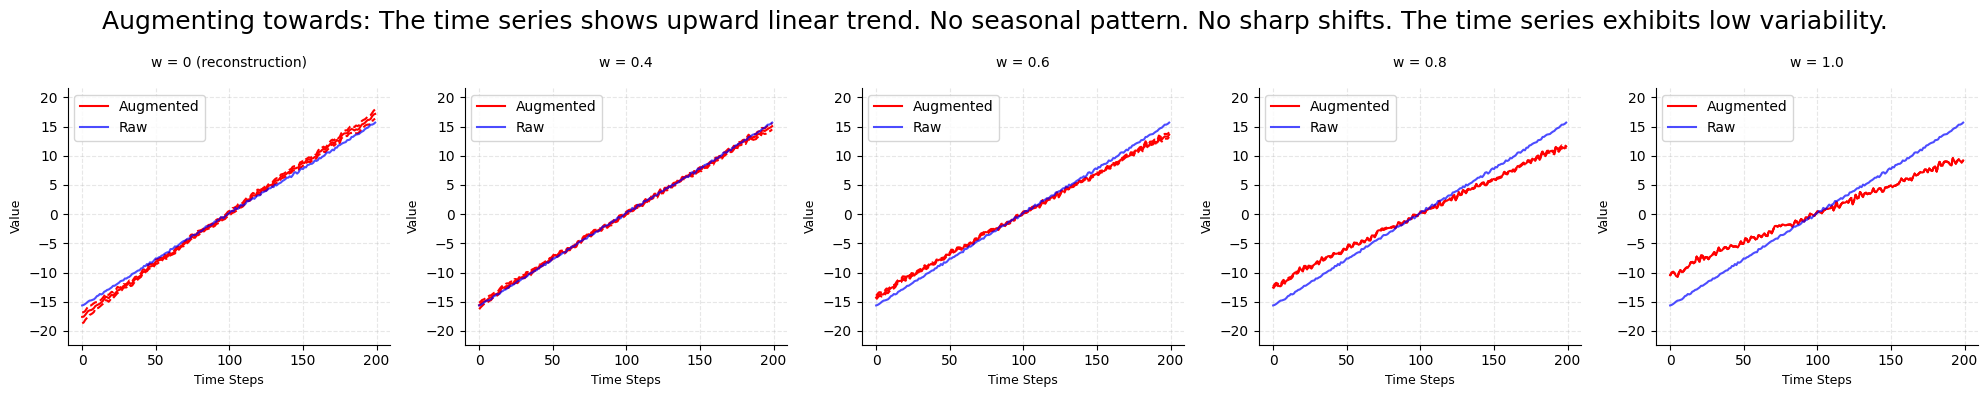

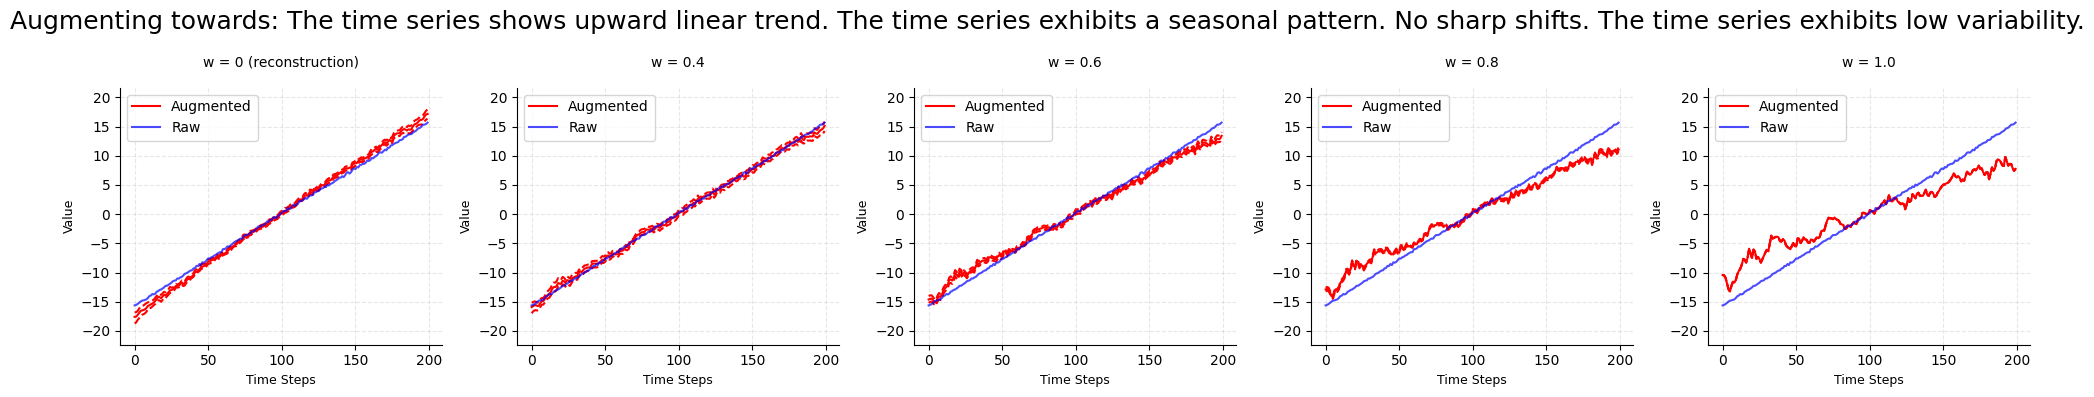

0    The time series exhibits a seasonal pattern.
Name: segment2, dtype: object


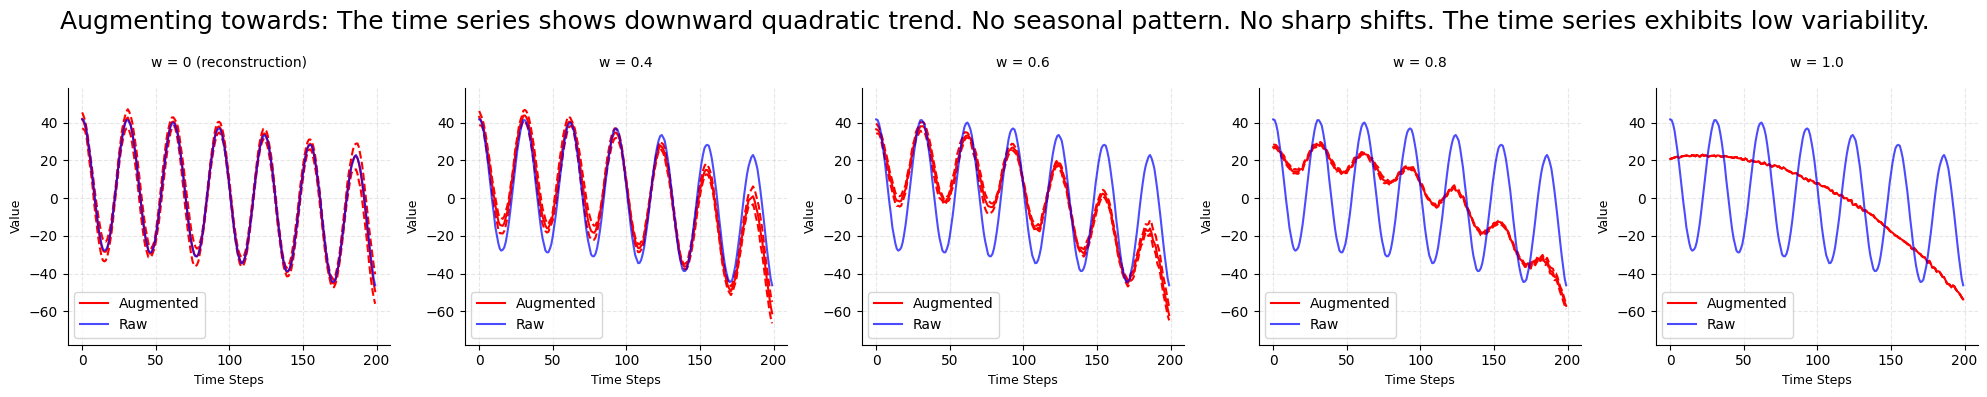

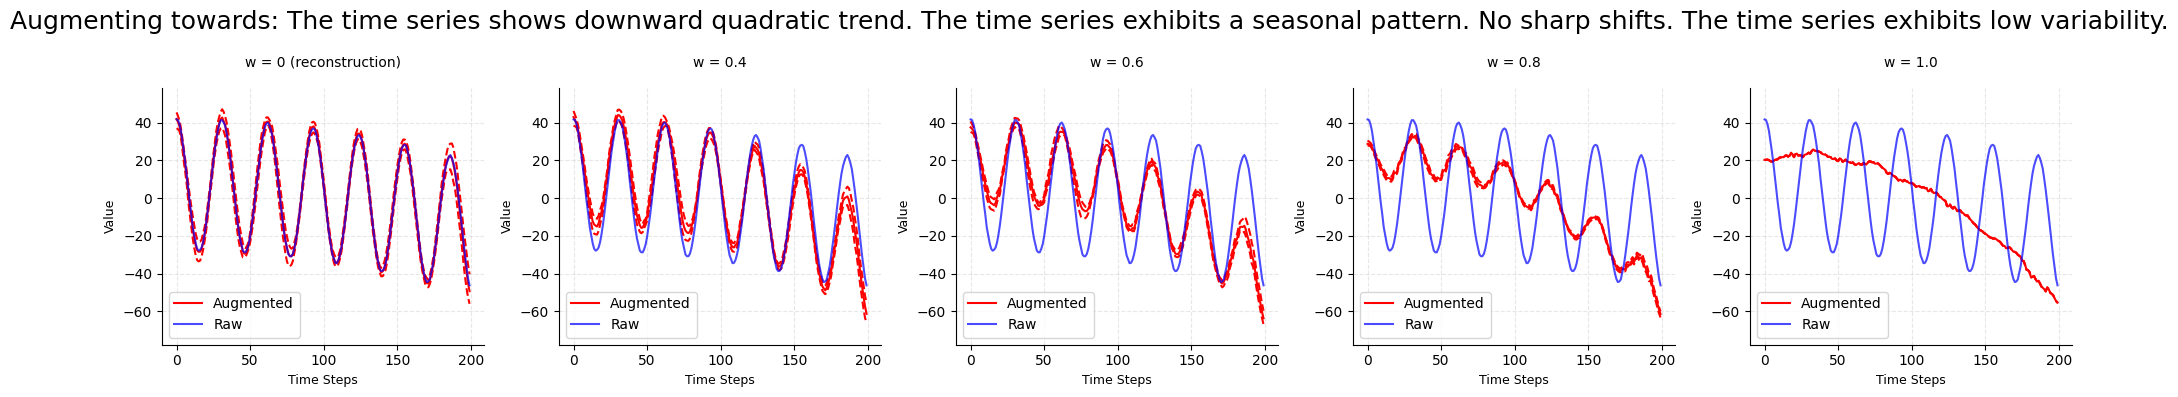

0    No sharp shifts.
Name: segment3, dtype: object


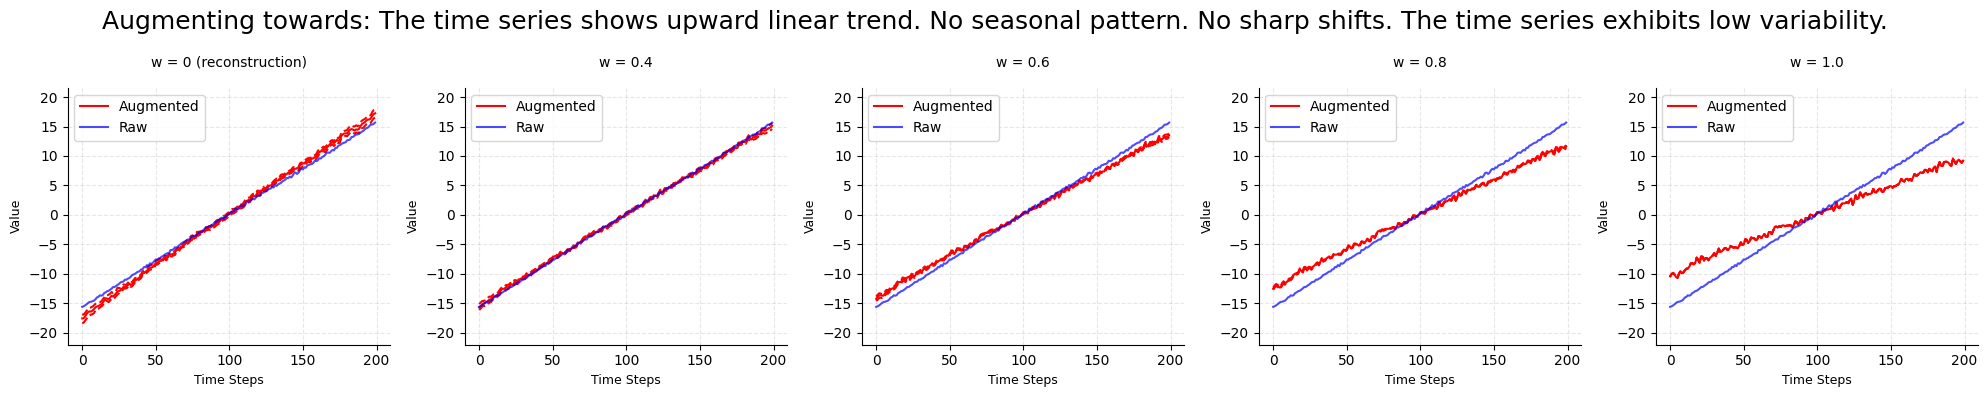

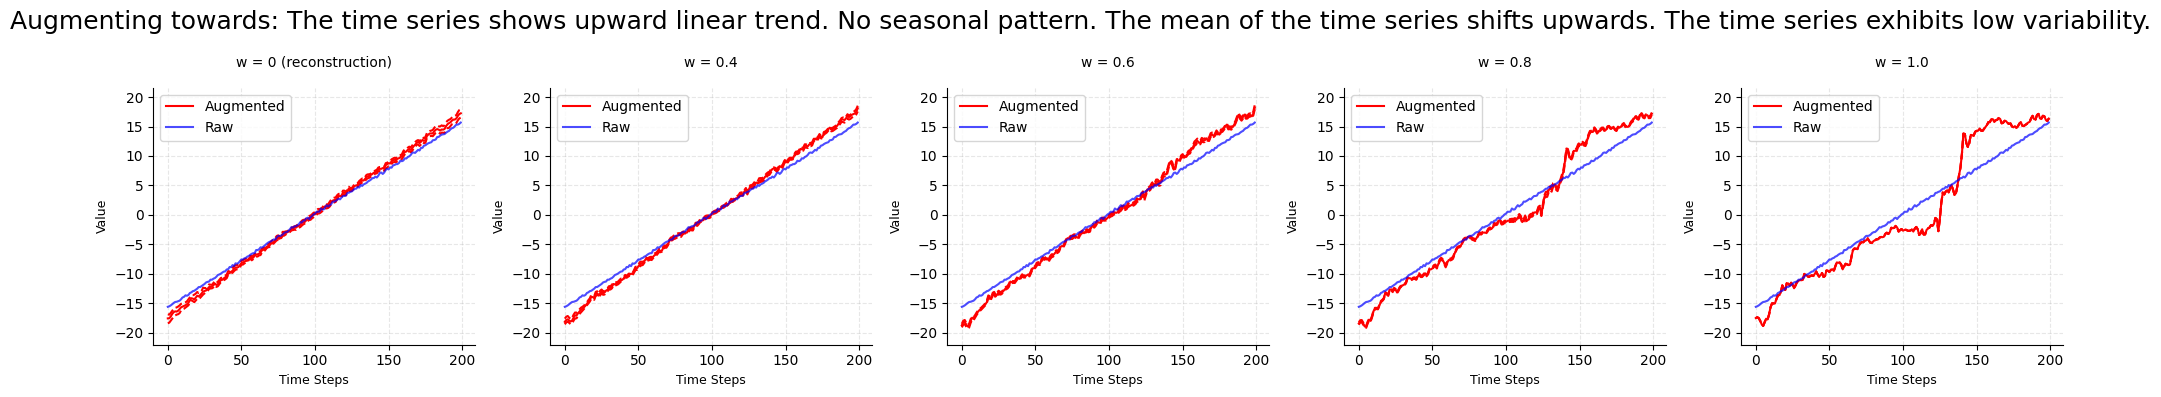

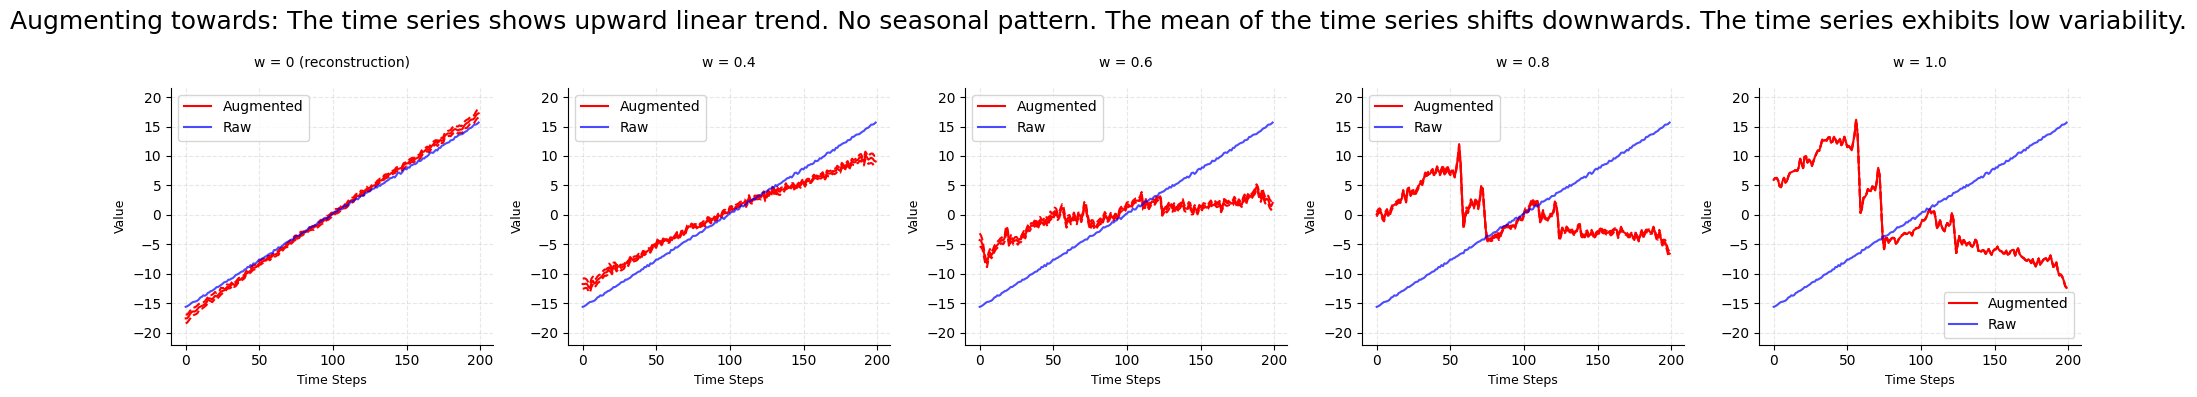

0    The mean of the time series shifts upwards.
Name: segment3, dtype: object


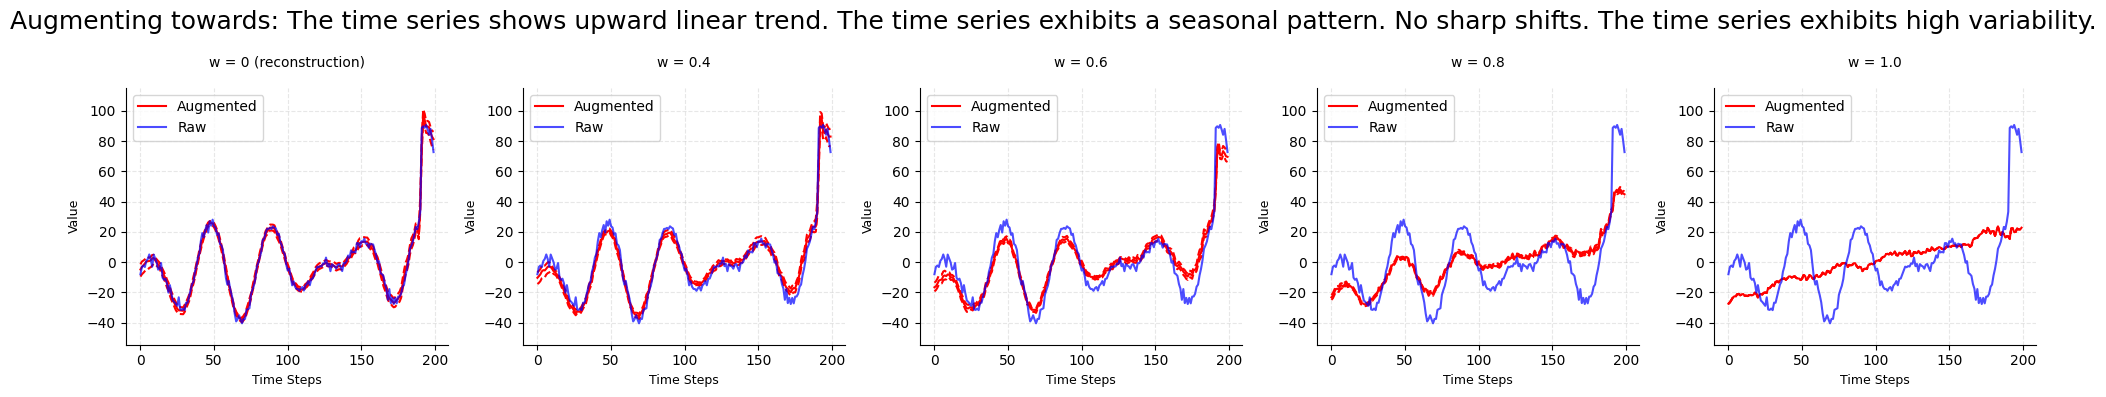

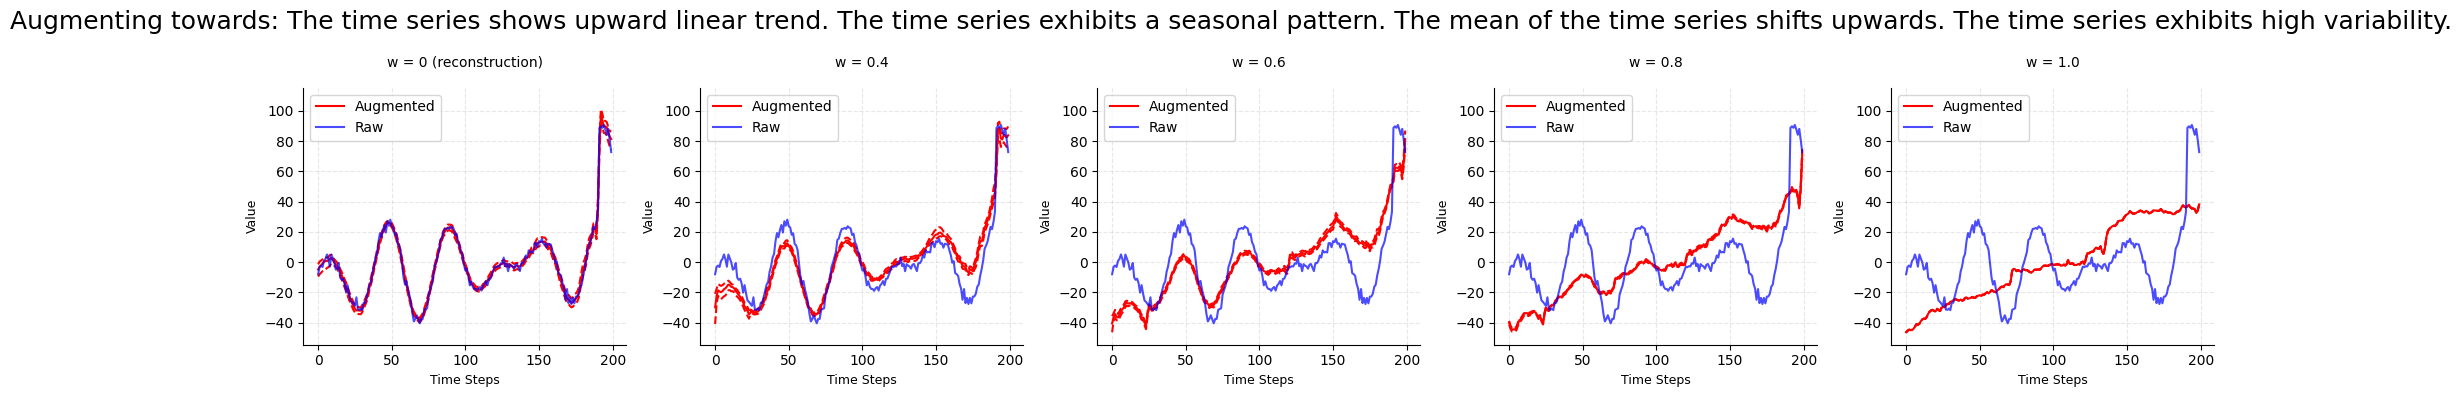

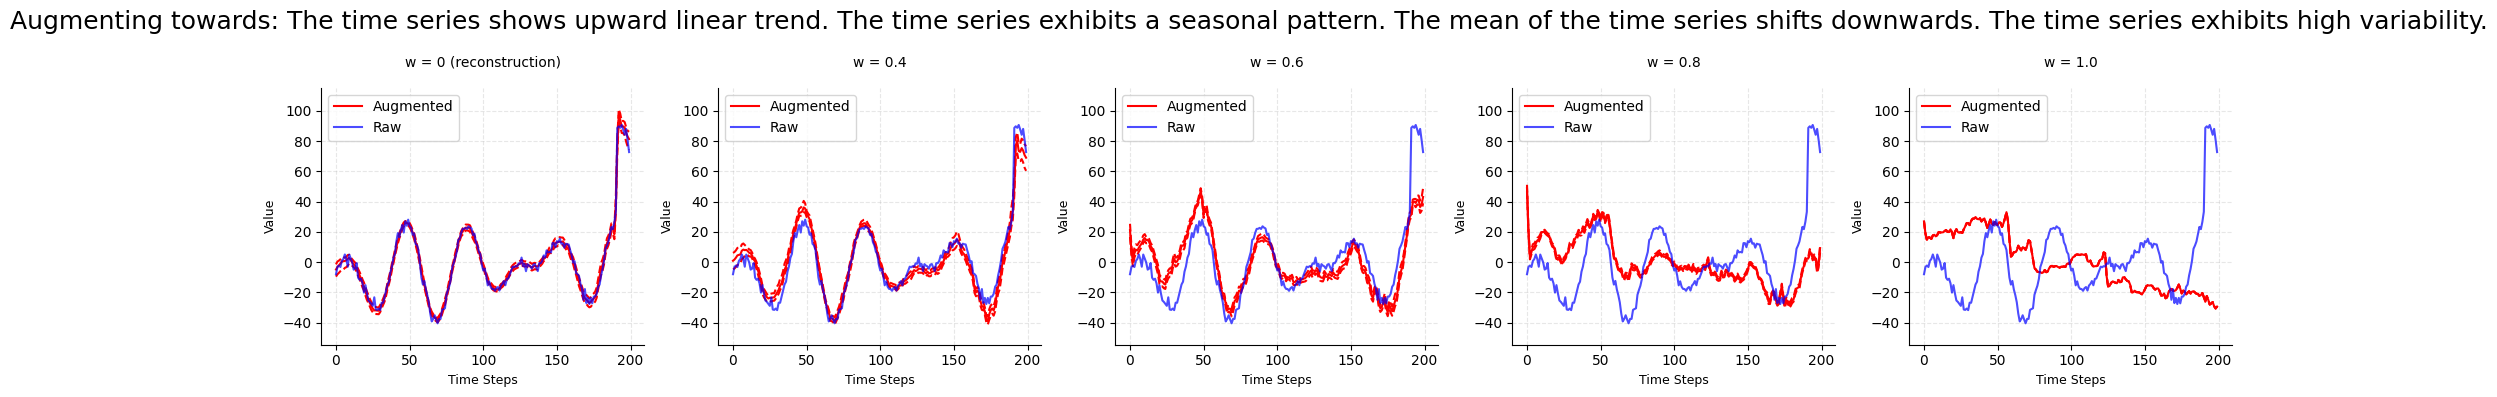

0    The mean of the time series shifts downwards.
Name: segment3, dtype: object


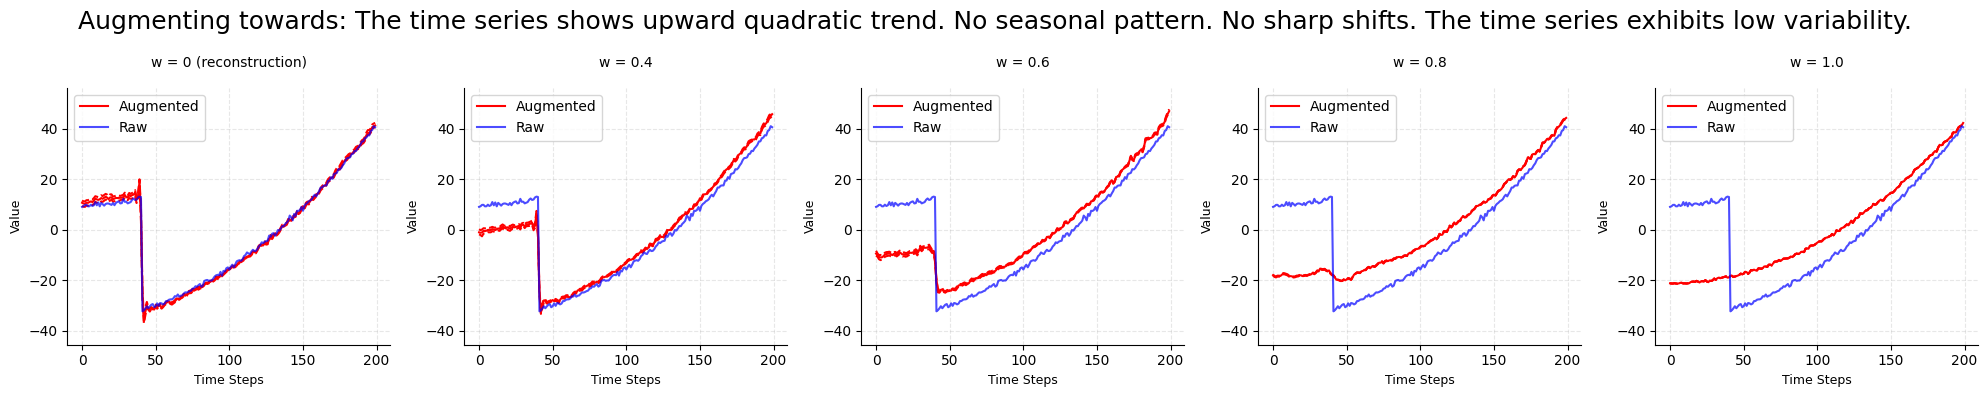

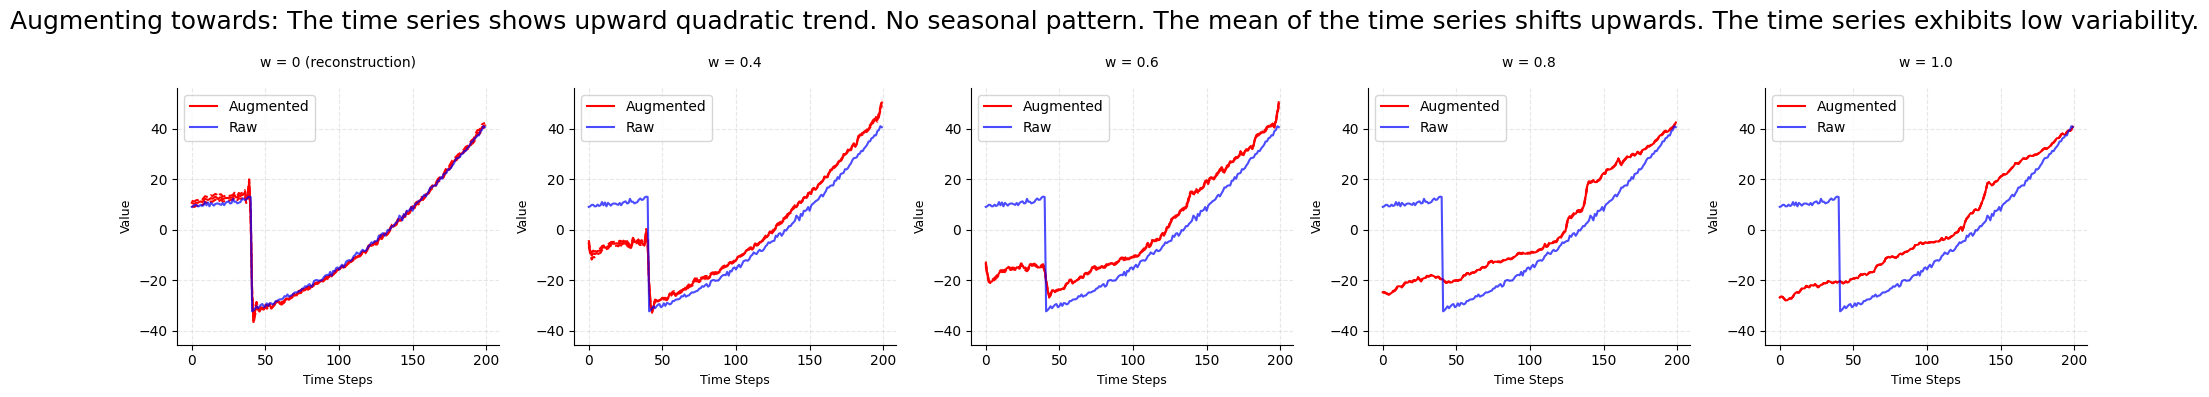

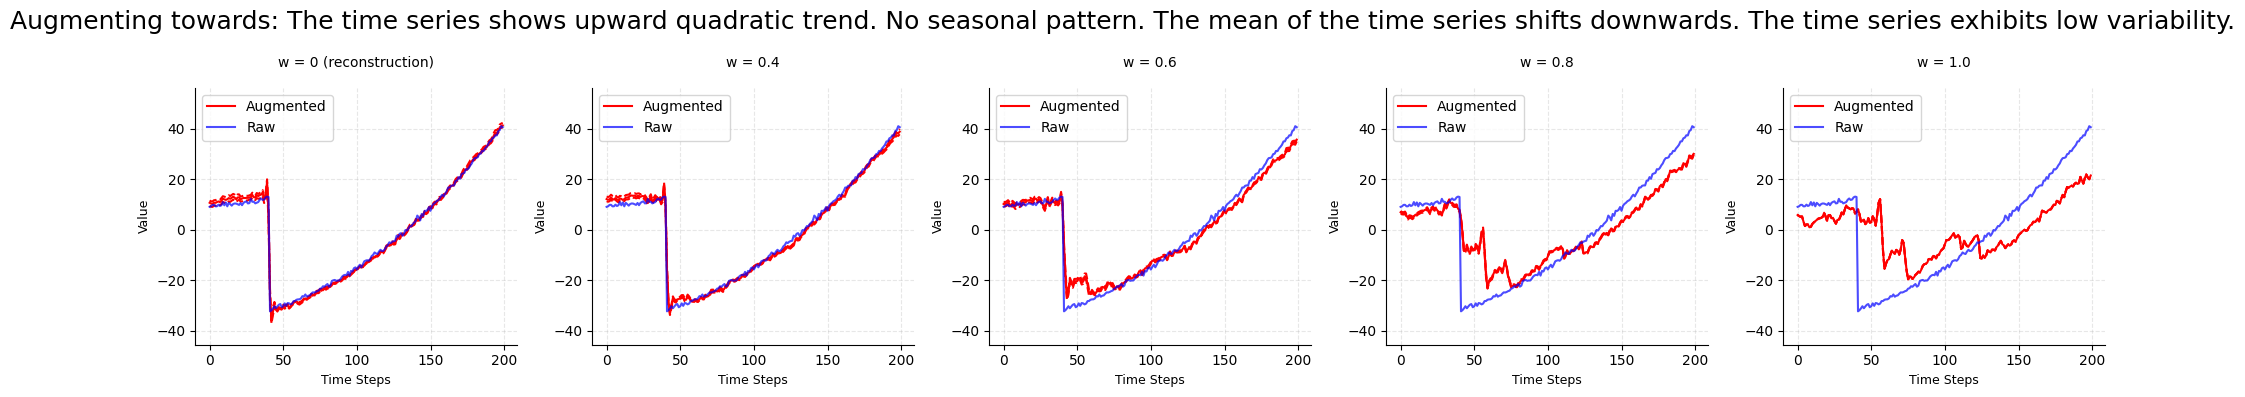

0    The time series exhibits low variability.
Name: segment4, dtype: object


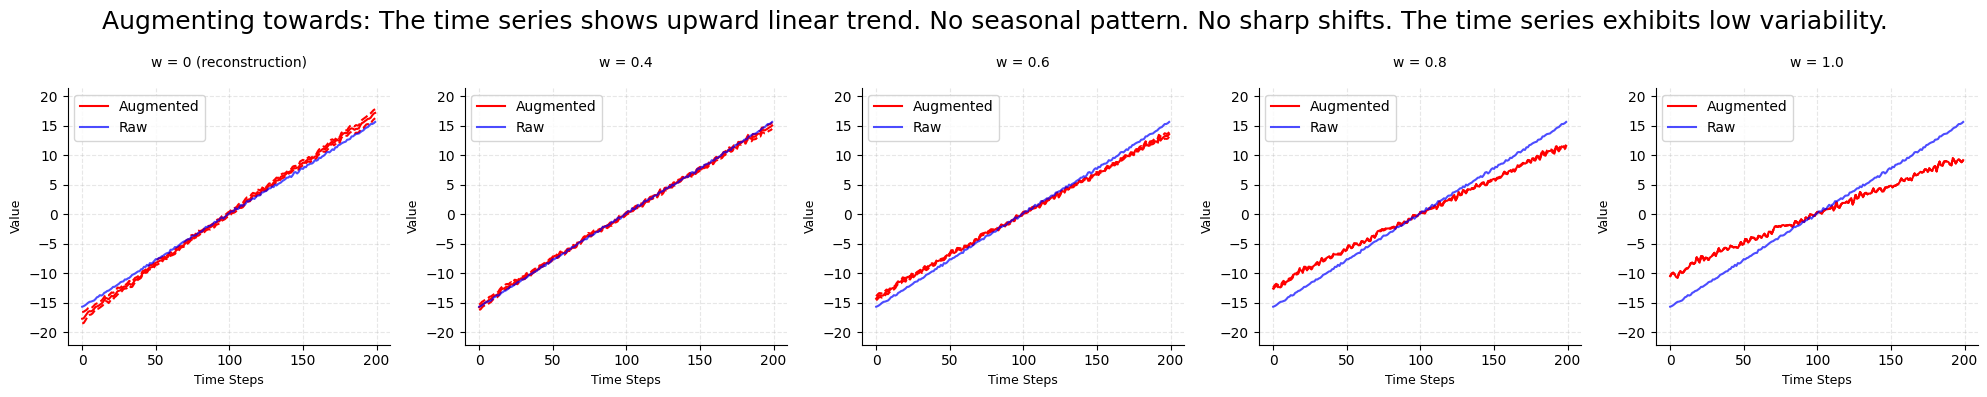

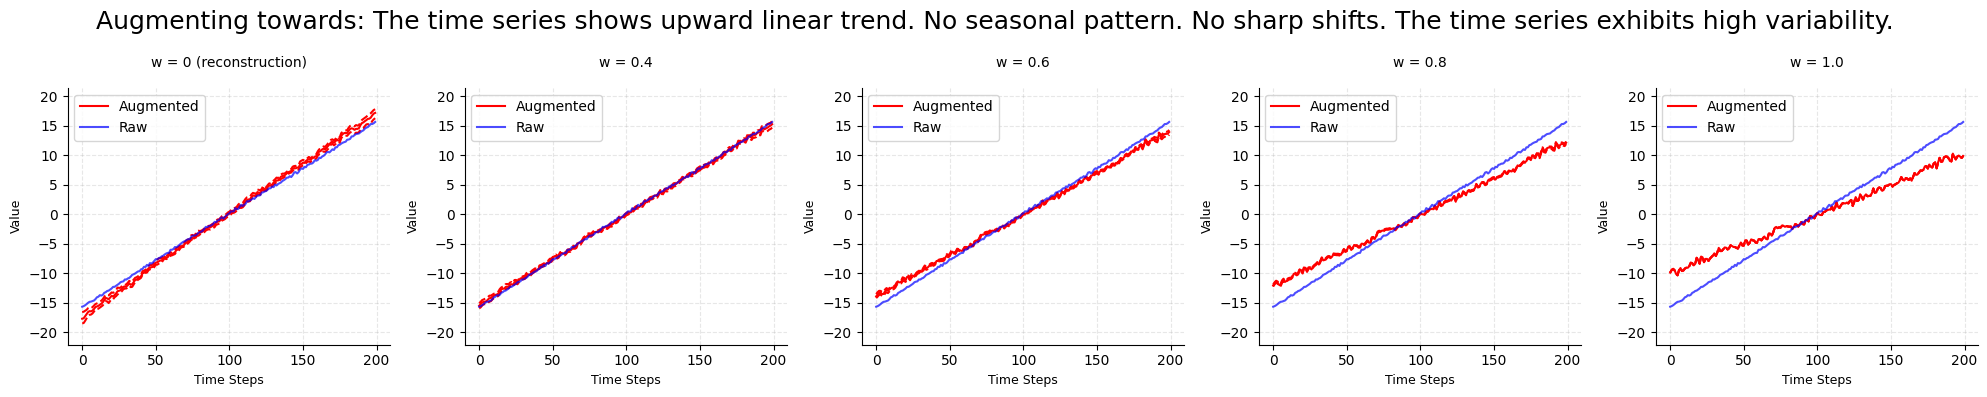

0    The time series exhibits high variability.
Name: segment4, dtype: object


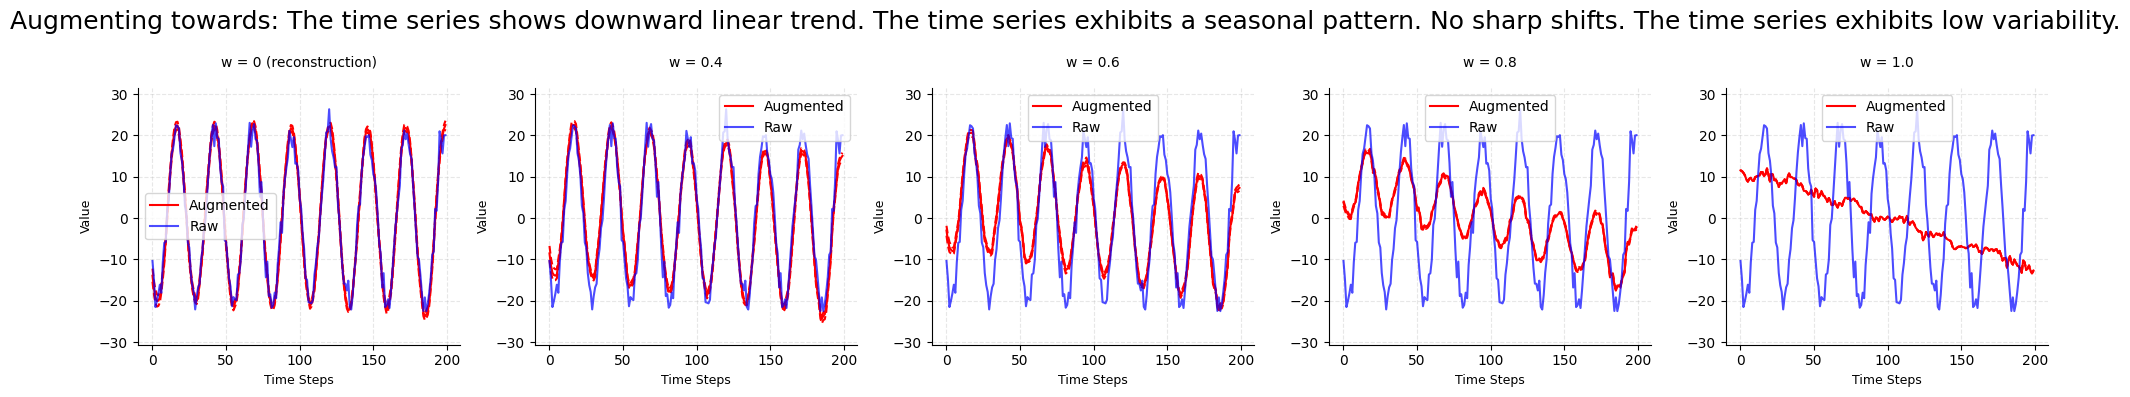

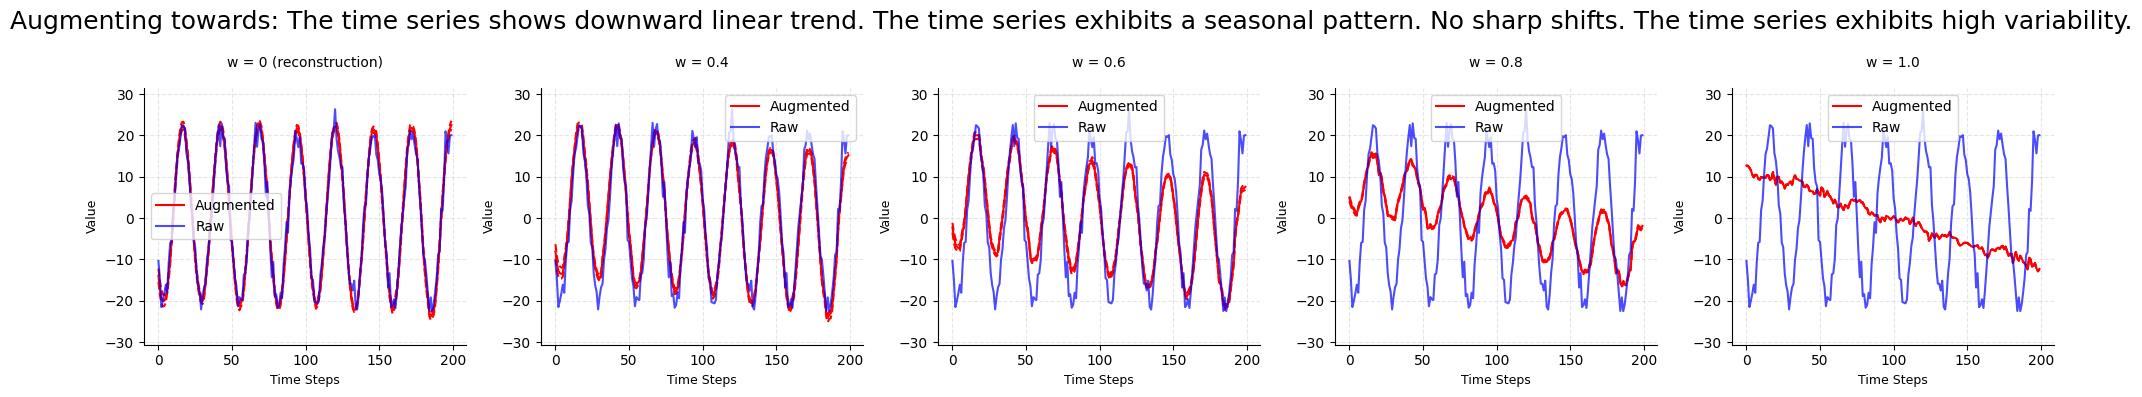

In [6]:
tid=0
# viz_generation_marginal(df_train, model, config_dict, tid=tid)
viz_generation_conditional(df_train, model, config_dict, tid=tid, sampling=True, b=100, ep=200)

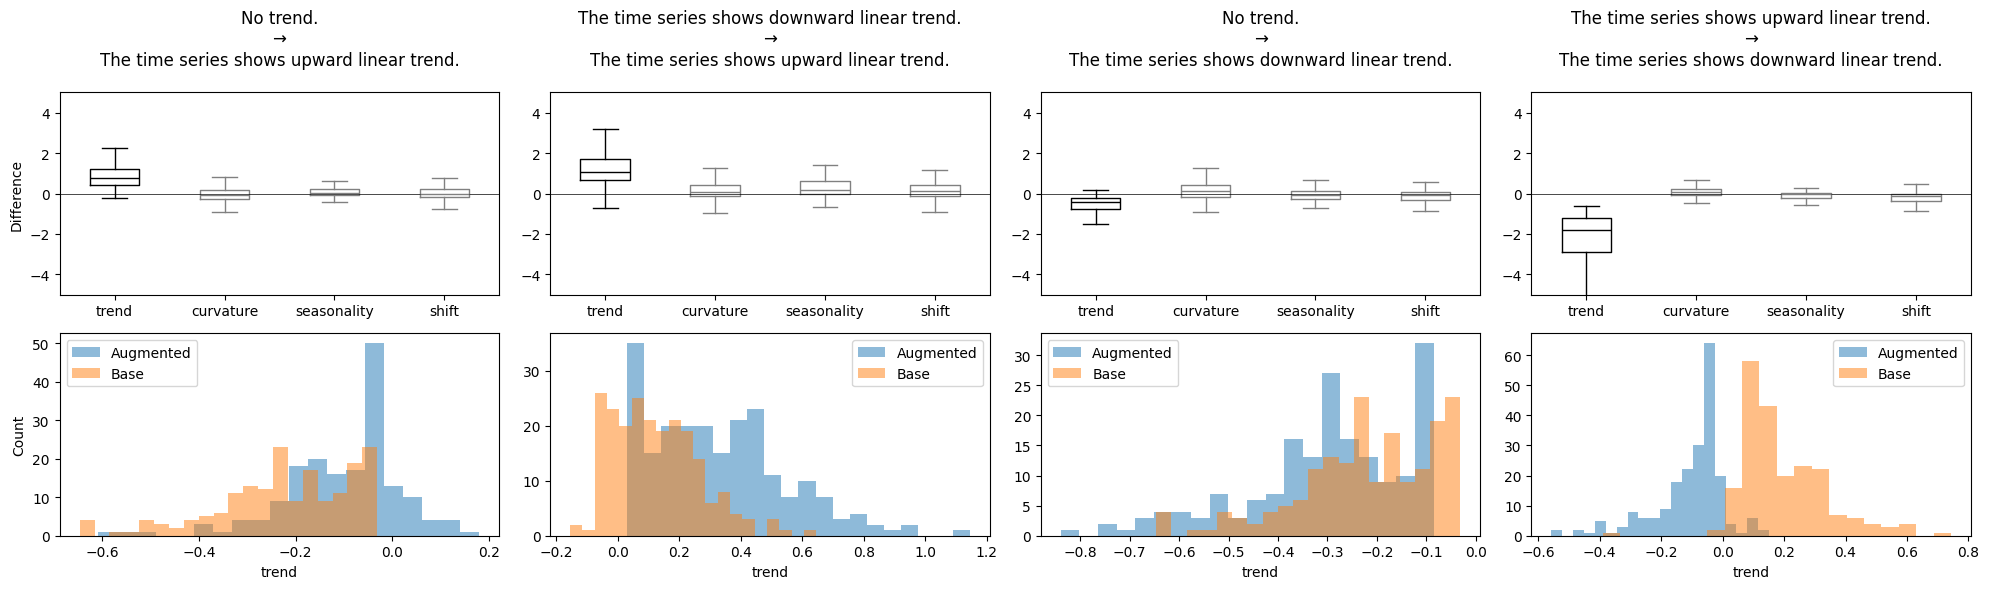

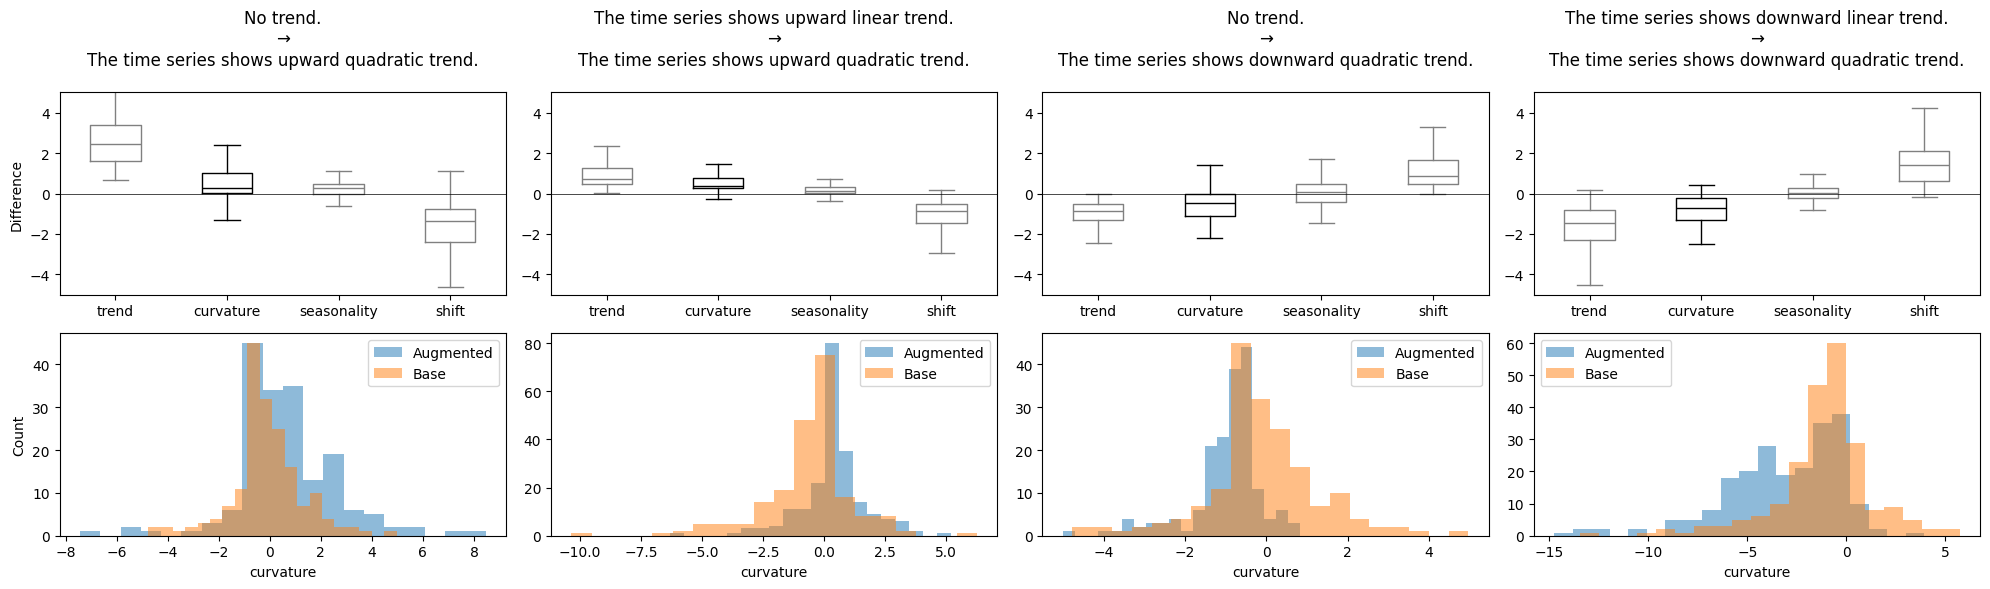

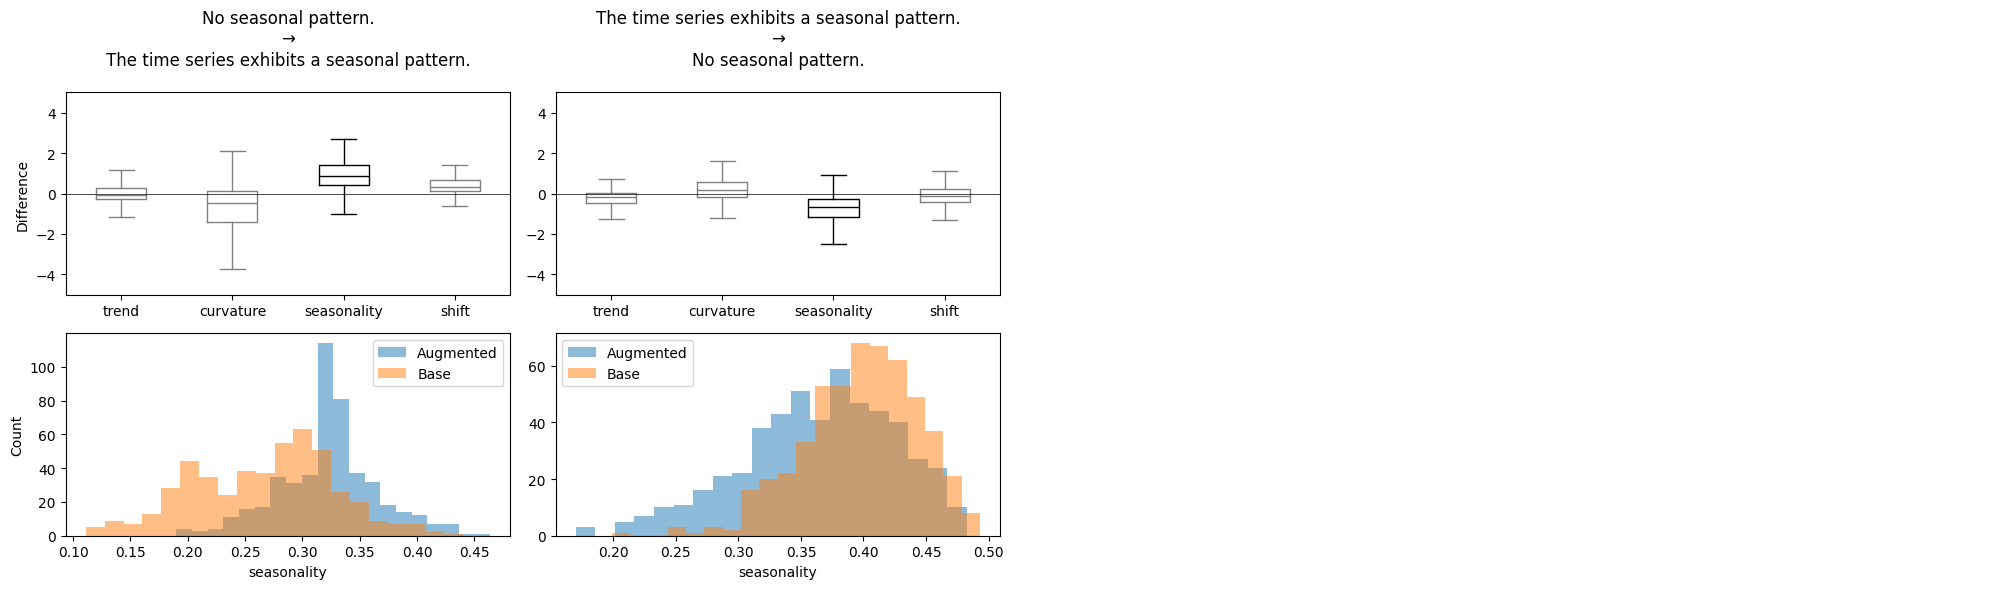

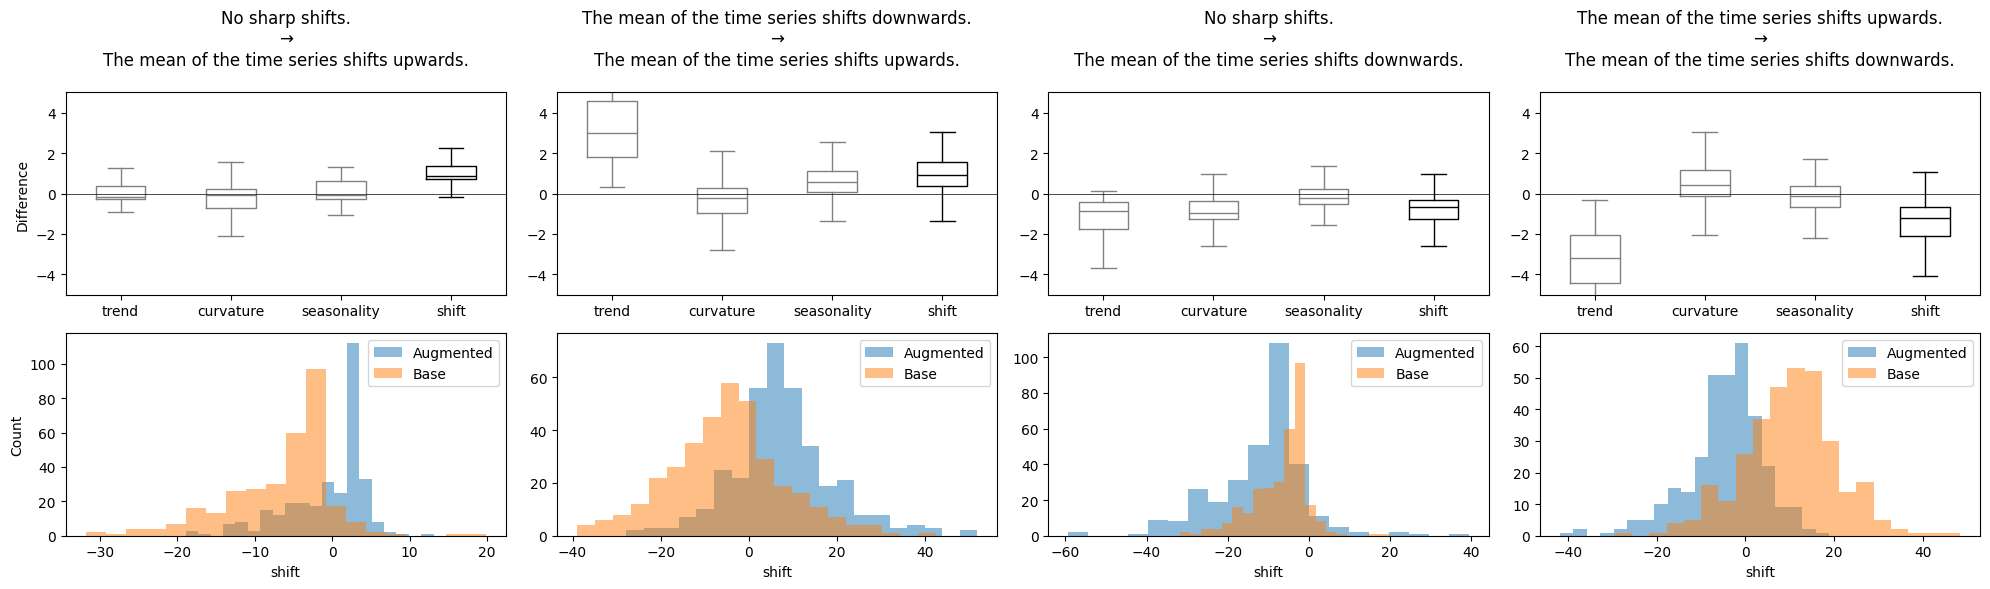

In [60]:
# Math eval
if overwrite or (not os.path.exists(output_dir+'/df_stats_all.pt.gz')):
    # calculate the properties of the generated time series
    df = df_test.sample(1000)
    df_stats_all = eval_math_properties(df, model, config_dict, type = "conditional", w = 0.8)
    
    # Save using PyTorch with gzip compression
    buffer = io.BytesIO()
    torch.save(df_stats_all, buffer)
    with gzip.open(output_dir+'/df_stats_all.pt.gz', 'wb') as f:
        f.write(buffer.getvalue())
else:
    # Load compressed file
    with gzip.open(output_dir+'/df_stats_all.pt.gz', 'rb') as f:
        buffer = io.BytesIO(f.read())
        df_stats_all = torch.load(buffer, map_location=device)

# Define the base augmentation pairs
base_aug_dict = {'trend': [('No trend.', 'The time series shows upward linear trend.'), 
                            ('The time series shows downward linear trend.', 'The time series shows upward linear trend.'),
                            ('No trend.', 'The time series shows downward linear trend.'), 
                            ('The time series shows upward linear trend.', 'The time series shows downward linear trend.')],
                    'curvature': [('No trend.', 'The time series shows upward quadratic trend.'),
                                  ('The time series shows upward linear trend.', 'The time series shows upward quadratic trend.'),
                                  ('No trend.', 'The time series shows downward quadratic trend.'),
                                  ('The time series shows downward linear trend.', 'The time series shows downward quadratic trend.')],
                    'seasonality': [('No seasonal pattern.', 'The time series exhibits a seasonal pattern.'),
                                ('The time series exhibits a seasonal pattern.', 'No seasonal pattern.')],
                    'shift': [('No sharp shifts.', 'The mean of the time series shifts upwards.'),
                            ('The mean of the time series shifts downwards.', 'The mean of the time series shifts upwards.'),
                            ('No sharp shifts.', 'The mean of the time series shifts downwards.'),
                            ('The mean of the time series shifts upwards.', 'The mean of the time series shifts downwards.')],
                #     'variability': [("The time series exhibits low variability.", "The time series exhibits high variability."),
                #                 ('The time series exhibits high variability.', "The time series exhibits low variability.")]
                    }

df_stats = eng_math_diff_multiple(df_stats_all, base_aug_dict, metrics=['trend', 'curvature', 'seasonality', 'shift'])# , 'variability'

In [16]:
overwrite = False
# argument dictionary {y_col:conditions}
args0 = {'segment1': None,
        'segment2': None,
        'segment3': None
        }

args1 = {'segment1': [('segment2', 'No seasonal pattern.'), ('segment3', 'No sharp shifts.')],
        'segment2': [('segment1', 'No trend.'), ('segment3', 'No sharp shifts.')],
        'segment3': [('segment1', 'No trend.'), ('segment2', 'No seasonal pattern.')]
        }

args2 = {'segment1': [('segment2', 'The time series exhibits a seasonal pattern.'), ('segment3', 'The mean of the time series shifts upwards.')],
        'segment2': [('segment1', 'The time series shows upward linear trend.'), ('segment3', 'The mean of the time series shifts upwards.')],
        'segment3': [('segment1', 'The time series shows upward linear trend.'), ('segment2', 'The time series exhibits a seasonal pattern.')]
        }

args_ls = [args0, args1, args2]
filename = output_dir+'/df_dists_all.pt.gz'
if overwrite or (not os.path.exists(filename)):
    res_all = []
    for args in args_ls:
        dists_dict = {}
        for y_col in args.keys():
            print(y_col)
            df_dists = eval_ts_distances(df_test,
                                        model, 
                                        config_dict, 
                                        w = 0.8,
                                        y_col = y_col,
                                        conditions = args[y_col],
                                        b = 500)
            dists_dict[y_col] = df_dists

        # Save using PyTorch with gzip compression
        res = {'args':args, 'dists_dict':dists_dict}
        res_all.append(res)

    buffer = io.BytesIO()
    torch.save(res_all, buffer)
    with gzip.open(filename, 'wb') as f: f.write(buffer.getvalue())
else:
    # Load compressed file
    with gzip.open(filename, 'rb') as f:
        buffer = io.BytesIO(f.read())
        res_all = torch.load(buffer, map_location=device)



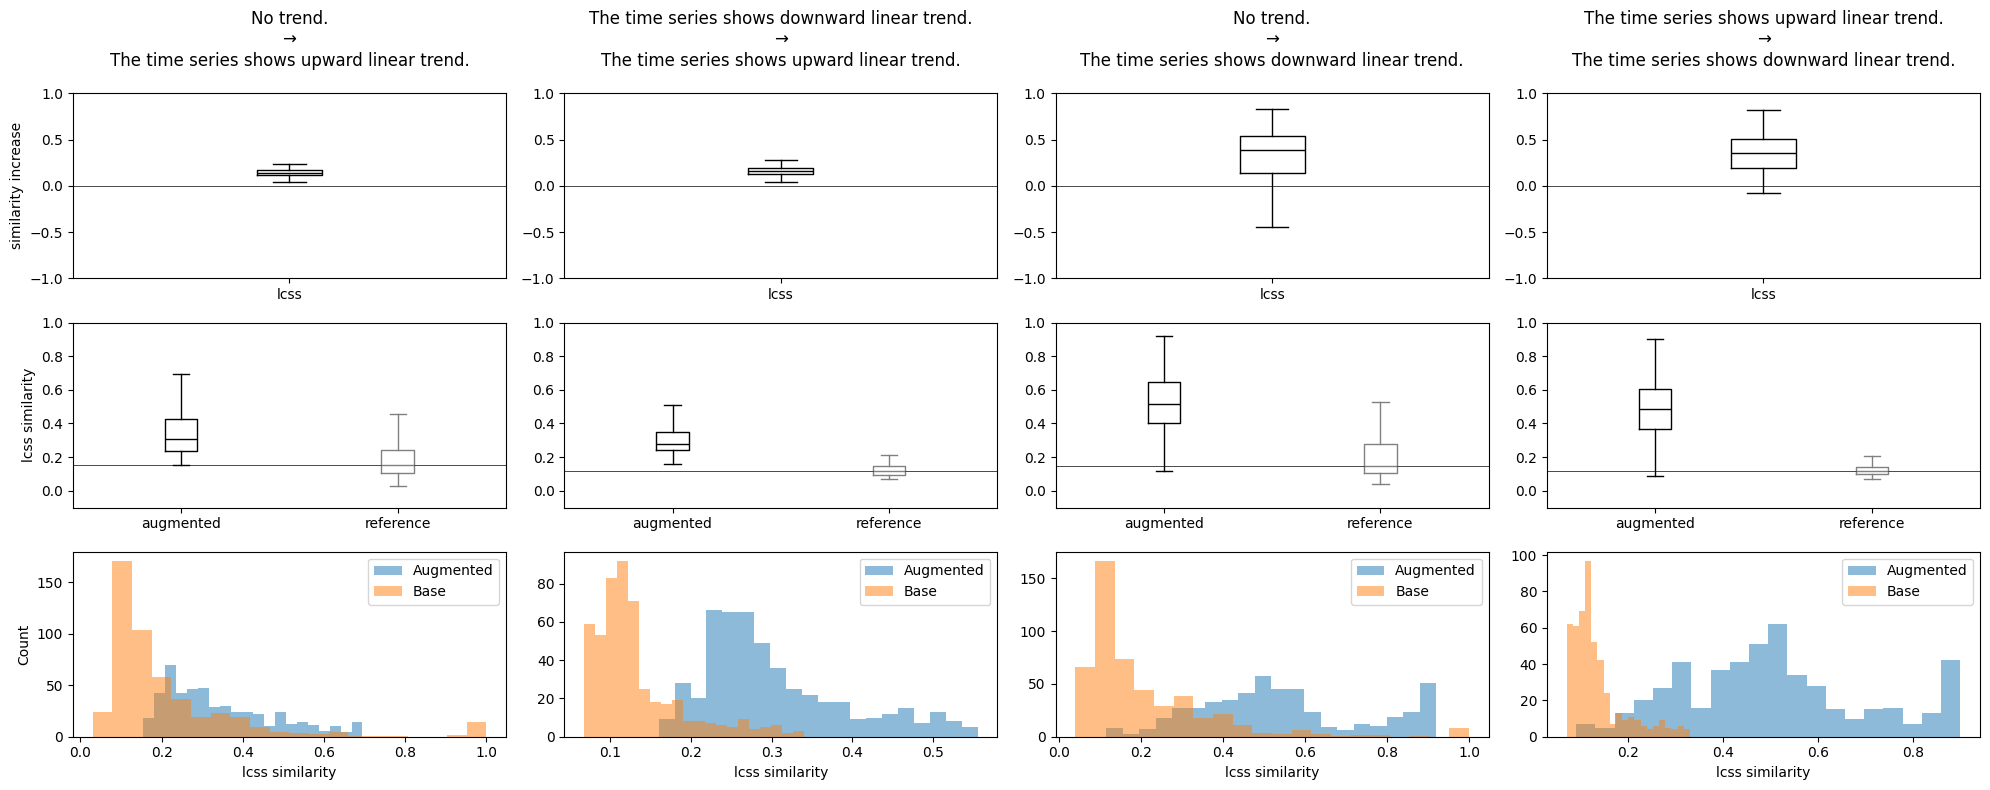

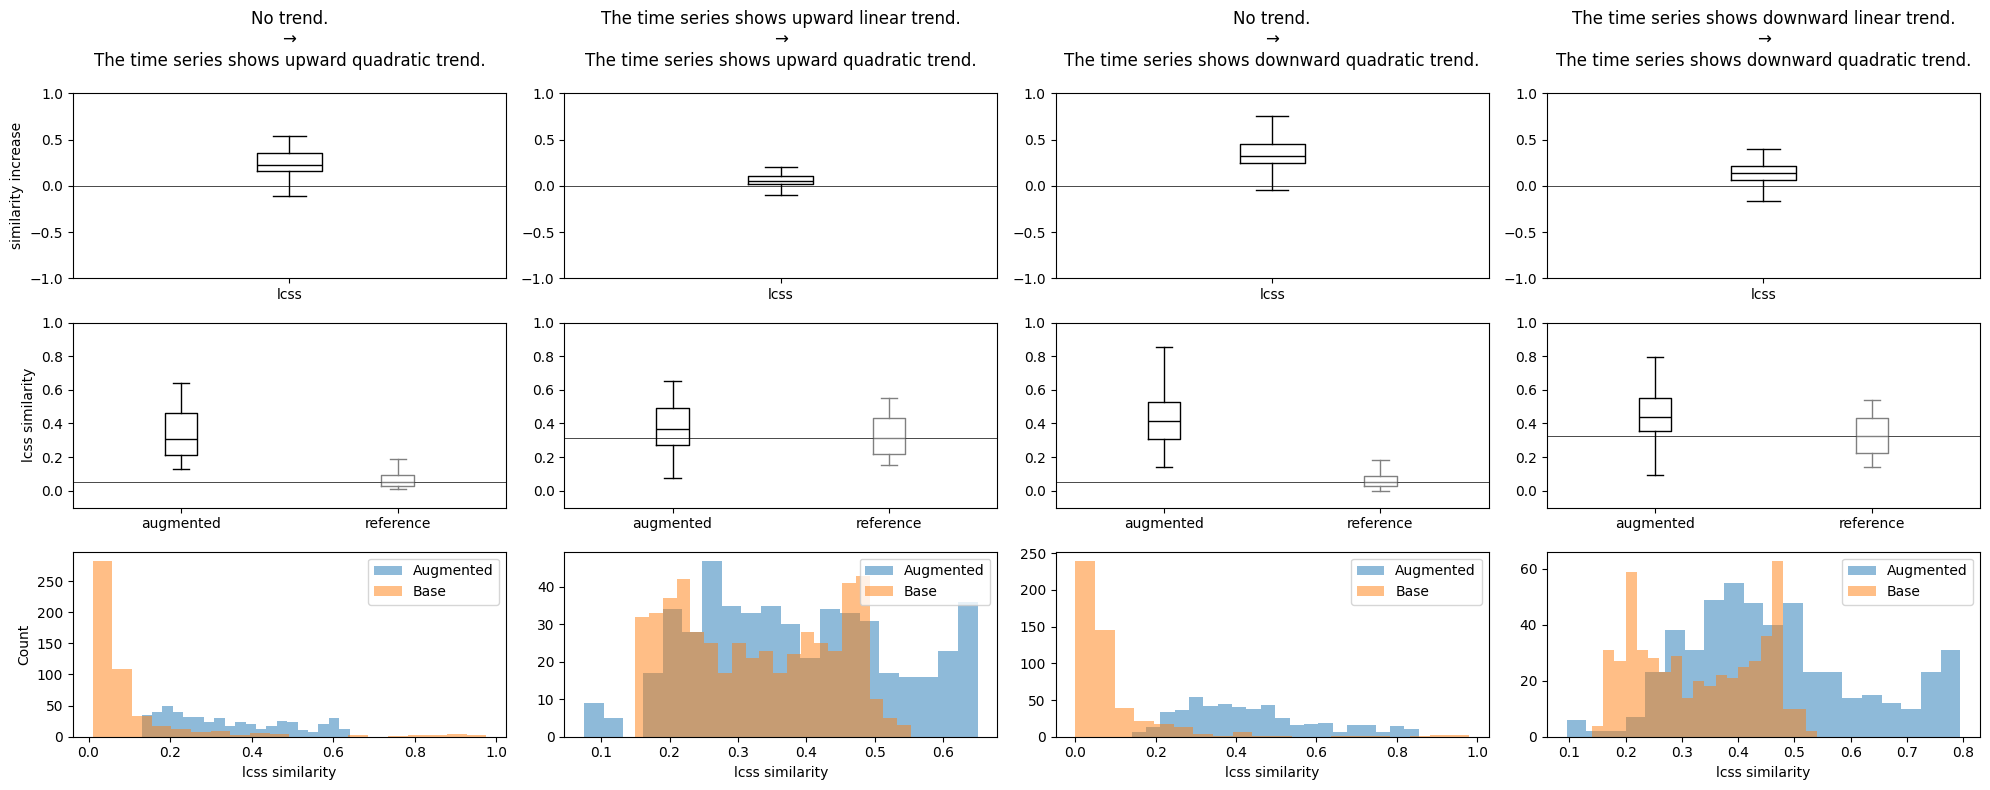

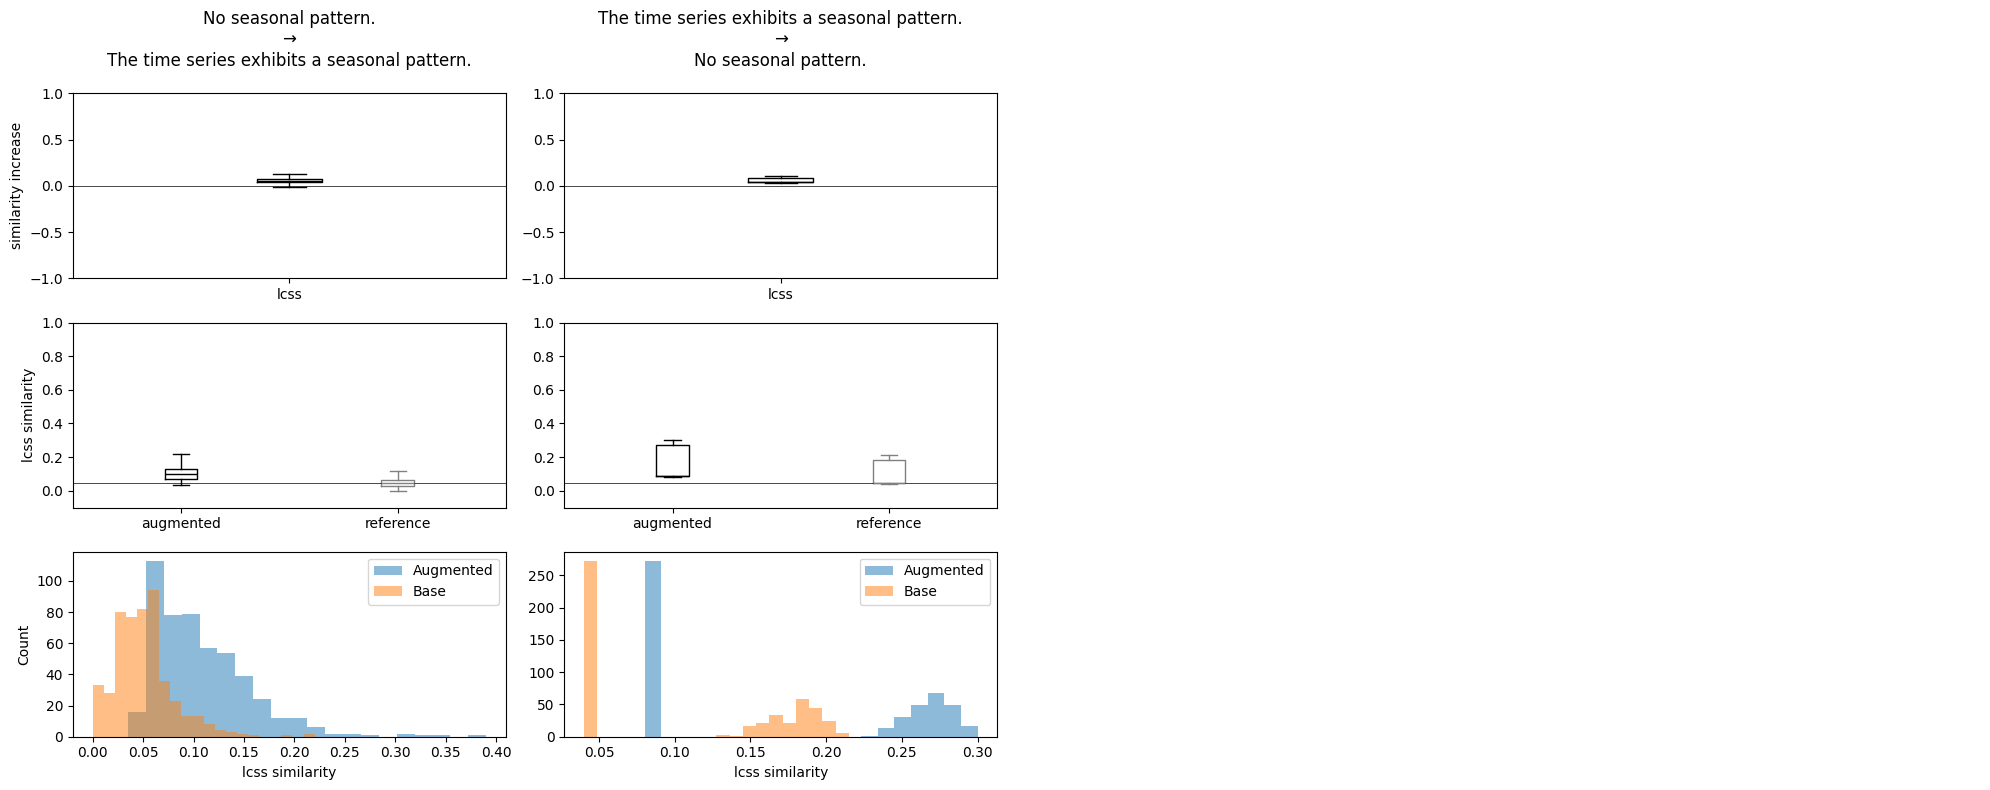

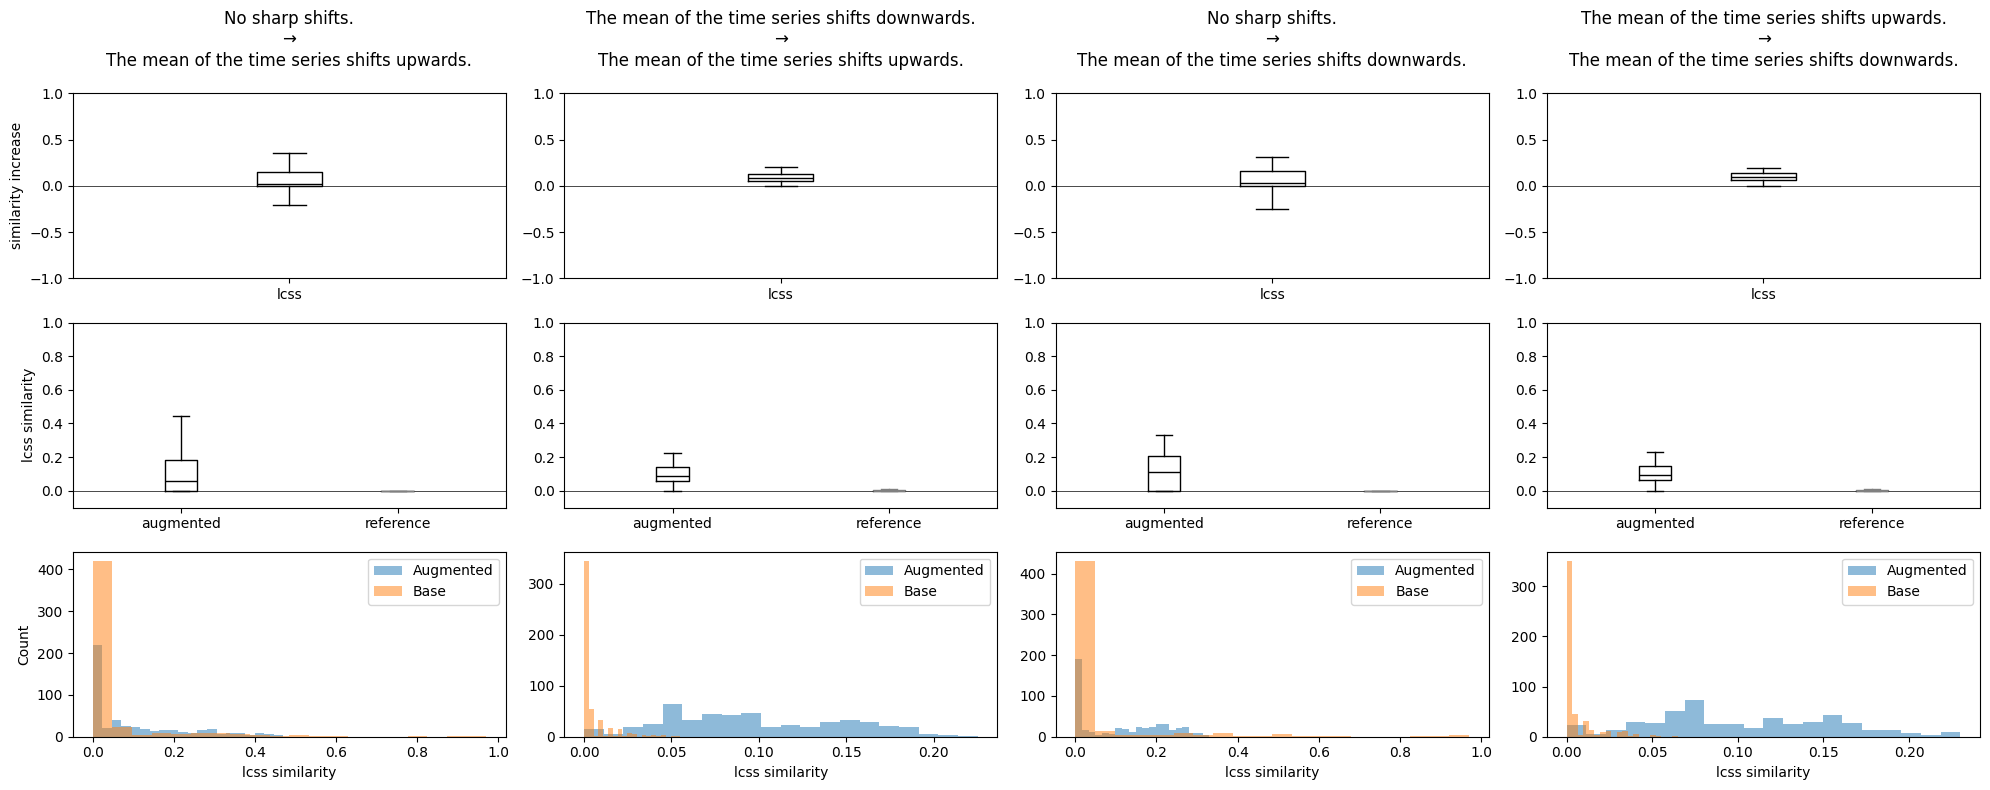

In [96]:
# Define the base augmentation pairs
base_aug_dict = {'trend': [('No trend.', 'The time series shows upward linear trend.'), 
                            ('The time series shows downward linear trend.', 'The time series shows upward linear trend.'),
                            ('No trend.', 'The time series shows downward linear trend.'), 
                            ('The time series shows upward linear trend.', 'The time series shows downward linear trend.')],
                'curvature': [('No trend.', 'The time series shows upward quadratic trend.'),
                                ('The time series shows upward linear trend.', 'The time series shows upward quadratic trend.'),
                                ('No trend.', 'The time series shows downward quadratic trend.'),
                                ('The time series shows downward linear trend.', 'The time series shows downward quadratic trend.')],
                'seasonality': [('No seasonal pattern.', 'The time series exhibits a seasonal pattern.'),
                            ('The time series exhibits a seasonal pattern.', 'No seasonal pattern.')],
                'shift': [('No sharp shifts.', 'The mean of the time series shifts upwards.'),
                        ('The mean of the time series shifts downwards.', 'The mean of the time series shifts upwards.'),
                        ('No sharp shifts.', 'The mean of the time series shifts downwards.'),
                        ('The mean of the time series shifts upwards.', 'The mean of the time series shifts downwards.')],
                # 'variability': [("The time series exhibits low variability.", "The time series exhibits high variability."),
                #             ('The time series exhibits high variability.', "The time series exhibits low variability.")]
                }
df_dists = pd.DataFrame()
for df in res_all[1]['dists_dict'].values():
    df_dists = pd.concat([df_dists, df], ignore_index=True)
# df_dists = res_all[0]['dists_dict']['segment1']
res_df = eng_dists_multiple(df_dists, base_aug_dict, metric = 'lcss')